Trajectories for epsilon_repulsive 1.00 saved to: C:\Users\khh38\Desktop\PhD\Class\comp-prob-solv\Project_2\trajectories_output\trajectories_epsilon_1.00.npy
Trajectories for epsilon_repulsive 1.01 saved to: C:\Users\khh38\Desktop\PhD\Class\comp-prob-solv\Project_2\trajectories_output\trajectories_epsilon_1.01.npy
Trajectories for epsilon_repulsive 1.02 saved to: C:\Users\khh38\Desktop\PhD\Class\comp-prob-solv\Project_2\trajectories_output\trajectories_epsilon_1.02.npy
Trajectories for epsilon_repulsive 1.03 saved to: C:\Users\khh38\Desktop\PhD\Class\comp-prob-solv\Project_2\trajectories_output\trajectories_epsilon_1.03.npy
Trajectories for epsilon_repulsive 1.04 saved to: C:\Users\khh38\Desktop\PhD\Class\comp-prob-solv\Project_2\trajectories_output\trajectories_epsilon_1.04.npy
Trajectories for epsilon_repulsive 1.05 saved to: C:\Users\khh38\Desktop\PhD\Class\comp-prob-solv\Project_2\trajectories_output\trajectories_epsilon_1.05.npy
Trajectories for epsilon_repulsive 1.06 saved to: C:

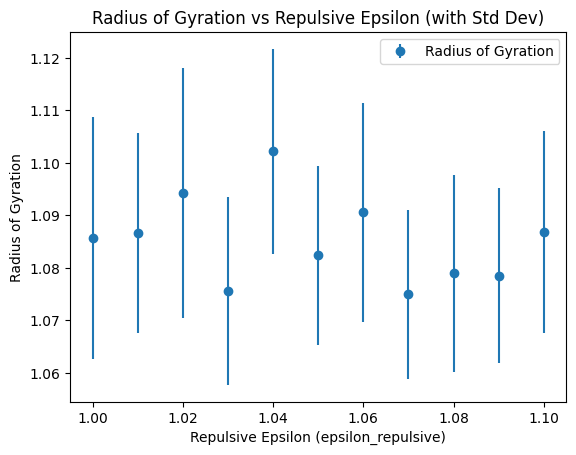

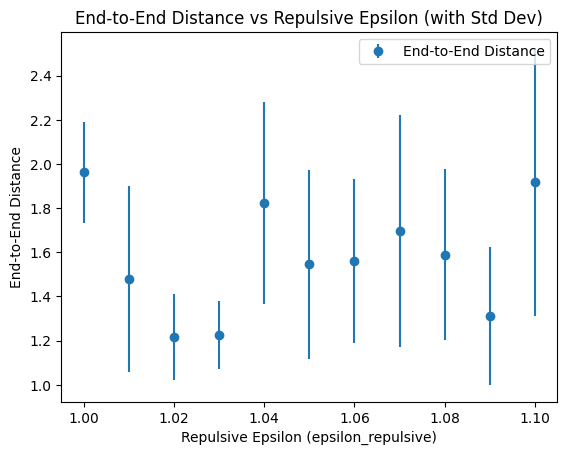

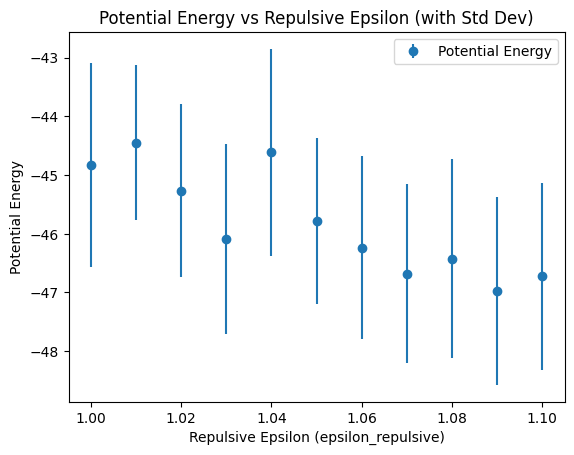

In [14]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from ase import Atoms
from ase.visualize import view
import os

# Set random seed for reproducibility
np.random.seed(42)

# Simulation parameters
dt = 0.01  # Time step
equilibration_steps = 40000  # Equilibration steps
sampling_steps = 10000  # Sampling steps
box_size = 100.0  # Size of the cubic box
k = 1.0  # Spring constant
mass = 1.0  # Particle mass
r0 = 1.0  # Equilibrium bond length
rescale_interval = 100  # Steps between velocity rescaling
n_particles = 20  # Number of particles
epsilon_attractive = 0.5  # Depth of attractive LJ potential
sigma = 1.0  # LJ potential parameter
cutoff = 1e-6 * sigma  # Reduce cutoff to limit attraction range
k_B = 1.0  # Boltzmann constant
target_temperature = 0.1  # Target temperature

# Directory to store trajectories
output_dir = r"C:\Users\khh38\Desktop\PhD\Class\comp-prob-solv\Project_2\trajectories_output"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Initialize Positions and Velocities with ASE Atoms
def initialize_chain_ase(n_particles, box_size, r0):
    """Initialize polymer chain positions with ASE."""
    positions = np.zeros((n_particles, 3))
    current_position = np.array([box_size / 2, box_size / 2, box_size / 2])
    positions[0] = current_position
    for i in range(1, n_particles):
        direction = np.random.randn(3)
        direction /= np.linalg.norm(direction)
        next_position = current_position + r0 * direction
        positions[i] = next_position % box_size
        current_position = positions[i]

    # Create ASE Atoms object
    polymer_chain = Atoms(positions=positions, symbols='C' * n_particles, cell=[box_size, box_size, box_size], pbc=True)
    return polymer_chain

def initialize_velocities(n_particles, target_temperature, mass):
    velocities = np.random.normal(0, np.sqrt(k_B * target_temperature / mass), (n_particles, 3))
    velocities -= np.mean(velocities, axis=0)  # Remove net momentum
    return velocities

# Apply Periodic Boundary Conditions
def apply_pbc(position, box_size):
    return position % box_size

# Compute Forces
def minimum_image(displacement, box_size):
    return displacement - box_size * np.round(displacement / box_size)

# Harmonic Forces
def compute_harmonic_forces(positions, k, r0, box_size):
    forces = np.zeros_like(positions)
    for i in range(len(positions) - 1):
        displacement = positions[i + 1] - positions[i]
        displacement = minimum_image(displacement, box_size)
        distance = np.linalg.norm(displacement)
        if distance != 0:
            force_magnitude = -k * (distance - r0)
            force = force_magnitude * (displacement / distance)
            forces[i] -= force
            forces[i + 1] += force
    return forces

# Lennard-Jones Forces
def compute_lennard_jones_forces(positions, box_size, epsilon_repulsive):
    forces = np.zeros_like(positions)
    for i in range(len(positions) - 1):
        for j in range(i + 1, len(positions)):
            displacement = positions[j] - positions[i]
            displacement = minimum_image(displacement, box_size)
            distance = np.linalg.norm(displacement)
            if distance < cutoff or distance == 0:
                continue  # Ignore interactions beyond the cutoff or zero distance
            if abs(i - j) == 2:
                epsilon_value = epsilon_repulsive
            elif abs(i - j) > 2:
                epsilon_value = epsilon_attractive
            else:
                continue
            force_magnitude = 24 * epsilon_value * ((sigma / distance)**12 - 0.5 * (sigma / distance)**6) / distance
            force = force_magnitude * (displacement / distance)
            forces[i] -= force
            forces[j] += force
    return forces

# Velocity Verlet Integration
def velocity_verlet(positions, velocities, forces, dt, mass, box_size, epsilon_repulsive):
    velocities += 0.5 * forces / mass * dt
    positions += velocities * dt
    positions = apply_pbc(positions, box_size)
    new_forces = compute_harmonic_forces(positions, k, r0, box_size) + compute_lennard_jones_forces(positions, box_size, epsilon_repulsive)
    velocities += 0.5 * new_forces / mass * dt
    return positions, velocities, new_forces

# Velocity Rescaling Thermostat
def rescale_velocities(velocities, target_temperature, mass):
    kinetic_energy = 0.5 * mass * np.sum(np.linalg.norm(velocities, axis=1)**2)
    current_temperature = (2 / 3) * kinetic_energy / (len(velocities) * k_B)
    scaling_factor = np.sqrt(target_temperature / current_temperature)
    velocities *= scaling_factor
    return velocities

# Analysis Functions
def calculate_radius_of_gyration(positions):
    center_of_mass = np.mean(positions, axis=0)
    Rg_squared = np.mean(np.sum((positions - center_of_mass)**2, axis=1))
    Rg = np.sqrt(Rg_squared)
    return Rg

def calculate_end_to_end_distance(positions):
    Ree = np.linalg.norm(positions[-1] - positions[0])
    return Ree

# Epsilon range for the simulation
epsilon_repulsive_values = np.linspace(1.0, 1.1, 11)

# Arrays to store results for different epsilon values
mean_Rg_values = []
std_Rg_values = []
mean_Ree_values = []
std_Ree_values = []
mean_potential_energies = []
std_potential_energies = []

# Loop over each epsilon_repulsive
for epsilon_repulsive in epsilon_repulsive_values:
    # Initialize positions and velocities with ASE
    polymer_chain = initialize_chain_ase(n_particles, box_size, r0)
    positions = polymer_chain.get_positions()
    velocities = initialize_velocities(n_particles, target_temperature, mass)
    forces = compute_harmonic_forces(positions, k, r0, box_size) + compute_lennard_jones_forces(positions, box_size, epsilon_repulsive)

    # Equilibration phase
    for step in range(equilibration_steps):
        positions, velocities, forces = velocity_verlet(positions, velocities, forces, dt, mass, box_size, epsilon_repulsive)
        polymer_chain.set_positions(positions)
        if step % rescale_interval == 0:
            velocities = rescale_velocities(velocities, target_temperature, mass)

    # Sampling phase
    Rg_values = []
    Ree_values = []
    potential_energies = []
    trajectories = []

    for step in range(sampling_steps):
        positions, velocities, forces = velocity_verlet(positions, velocities, forces, dt, mass, box_size, epsilon_repulsive)
        polymer_chain.set_positions(positions)  # Update ASE positions
        if step % rescale_interval == 0:
            velocities = rescale_velocities(velocities, target_temperature, mass)

        # Compute properties
        Rg = calculate_radius_of_gyration(positions)
        Ree = calculate_end_to_end_distance(positions)

        # Calculate potential energy
        E_harmonic = 0.0
        for i in range(n_particles - 1):
            displacement = positions[i + 1] - positions[i]
            displacement = minimum_image(displacement, box_size)
            distance = np.linalg.norm(displacement)
            E_harmonic += 0.5 * k * (distance - r0)**2

        E_LJ = 0.0
        for i in range(len(positions) - 1):
            for j in range(i + 1, len(positions)):
                displacement = positions[j] - positions[i]
                displacement = minimum_image(displacement, box_size)
                distance = np.linalg.norm(displacement)
                if distance < cutoff or distance == 0:
                    continue  # Ignore interactions beyond the cutoff or zero distance
                if abs(i - j) == 2:
                    epsilon_value = epsilon_repulsive
                elif abs(i - j) > 2:
                    epsilon_value = epsilon_attractive
                else:
                    continue
                E_LJ += 4 * epsilon_value * ((sigma / distance)**12 - (sigma / distance)**6)

        potential_energy = E_harmonic + E_LJ

        # Store results
        Rg_values.append(Rg)
        Ree_values.append(Ree)
        potential_energies.append(potential_energy)
        trajectories.append(positions.copy())

    # Convert lists to NumPy arrays
    Rg_values = np.array(Rg_values)
    Ree_values = np.array(Ree_values)
    potential_energies = np.array(potential_energies)
    trajectories = np.array(trajectories)

    # Save the trajectory data for the current epsilon value
    trajectory_file_path = os.path.join(output_dir, f"trajectories_epsilon_{epsilon_repulsive:.2f}.npy")
    np.save(trajectory_file_path, trajectories)
    print(f"Trajectories for epsilon_repulsive {epsilon_repulsive:.2f} saved to: {trajectory_file_path}")

    # Calculate mean and standard deviation for the current epsilon value
    mean_Rg_values.append(np.mean(Rg_values))
    std_Rg_values.append(np.std(Rg_values))

    mean_Ree_values.append(np.mean(Ree_values))
    std_Ree_values.append(np.std(Ree_values))

    mean_potential_energies.append(np.mean(potential_energies))
    std_potential_energies.append(np.std(potential_energies))

# Plotting the results with standard deviation
plt.figure()
plt.errorbar(epsilon_repulsive_values, mean_Rg_values, yerr=std_Rg_values, fmt='o', label='Radius of Gyration')
plt.xlabel('Repulsive Epsilon (epsilon_repulsive)')
plt.ylabel('Radius of Gyration')
plt.title('Radius of Gyration vs Repulsive Epsilon (with Std Dev)')
plt.legend()
plt.show()

plt.figure()
plt.errorbar(epsilon_repulsive_values, mean_Ree_values, yerr=std_Ree_values, fmt='o', label='End-to-End Distance')
plt.xlabel('Repulsive Epsilon (epsilon_repulsive)')
plt.ylabel('End-to-End Distance')
plt.title('End-to-End Distance vs Repulsive Epsilon (with Std Dev)')
plt.legend()
plt.show()

plt.figure()
plt.errorbar(epsilon_repulsive_values, mean_potential_energies, yerr=std_potential_energies, fmt='o', label='Potential Energy')
plt.xlabel('Repulsive Epsilon (epsilon_repulsive)')
plt.ylabel('Potential Energy')
plt.title('Potential Energy vs Repulsive Epsilon (with Std Dev)')
plt.legend()
plt.show()


In [15]:
# Print results for Radius of Gyration
print("Repulsive Epsilon vs Radius of Gyration")
print(f"{'Epsilon_Repulsive':>18} {'Mean Rg':>10} {'Std Rg':>10}")
for epsilon, mean_Rg, std_Rg in zip(epsilon_repulsive_values, mean_Rg_values, std_Rg_values):
    print(f"{epsilon:18.4f} {mean_Rg:10.4f} {std_Rg:10.4f}")

print("\nRepulsive Epsilon vs End-to-End Distance")
print(f"{'Epsilon_Repulsive':>18} {'Mean Ree':>10} {'Std Ree':>10}")
for epsilon, mean_Ree, std_Ree in zip(epsilon_repulsive_values, mean_Ree_values, std_Ree_values):
    print(f"{epsilon:18.4f} {mean_Ree:10.4f} {std_Ree:10.4f}")

print("\nRepulsive Epsilon vs Potential Energy")
print(f"{'Epsilon_Repulsive':>18} {'Mean PE':>10} {'Std PE':>10}")
for epsilon, mean_PE, std_PE in zip(epsilon_repulsive_values, mean_potential_energies, std_potential_energies):
    print(f"{epsilon:18.4f} {mean_PE:10.4f} {std_PE:10.4f}")


Repulsive Epsilon vs Radius of Gyration
 Epsilon_Repulsive    Mean Rg     Std Rg
            1.0000     1.0857     0.0231
            1.0100     1.0867     0.0191
            1.0200     1.0942     0.0238
            1.0300     1.0756     0.0179
            1.0400     1.1022     0.0196
            1.0500     1.0824     0.0171
            1.0600     1.0906     0.0209
            1.0700     1.0749     0.0161
            1.0800     1.0790     0.0187
            1.0900     1.0785     0.0167
            1.1000     1.0869     0.0192

Repulsive Epsilon vs End-to-End Distance
 Epsilon_Repulsive   Mean Ree    Std Ree
            1.0000     1.9623     0.2297
            1.0100     1.4781     0.4225
            1.0200     1.2180     0.1948
            1.0300     1.2240     0.1546
            1.0400     1.8233     0.4580
            1.0500     1.5451     0.4273
            1.0600     1.5611     0.3727
            1.0700     1.6957     0.5259
            1.0800     1.5895     0.3876
            1.09

Trajectories for epsilon_repulsive 1.10 saved to: C:\Users\khh38\Desktop\PhD\Class\comp-prob-solv\Project_2\trajectories_output\trajectories_epsilon_1.10.npy
Trajectories for epsilon_repulsive 1.11 saved to: C:\Users\khh38\Desktop\PhD\Class\comp-prob-solv\Project_2\trajectories_output\trajectories_epsilon_1.11.npy
Trajectories for epsilon_repulsive 1.12 saved to: C:\Users\khh38\Desktop\PhD\Class\comp-prob-solv\Project_2\trajectories_output\trajectories_epsilon_1.12.npy
Trajectories for epsilon_repulsive 1.13 saved to: C:\Users\khh38\Desktop\PhD\Class\comp-prob-solv\Project_2\trajectories_output\trajectories_epsilon_1.13.npy
Trajectories for epsilon_repulsive 1.14 saved to: C:\Users\khh38\Desktop\PhD\Class\comp-prob-solv\Project_2\trajectories_output\trajectories_epsilon_1.14.npy
Trajectories for epsilon_repulsive 1.16 saved to: C:\Users\khh38\Desktop\PhD\Class\comp-prob-solv\Project_2\trajectories_output\trajectories_epsilon_1.16.npy
Trajectories for epsilon_repulsive 1.17 saved to: C:

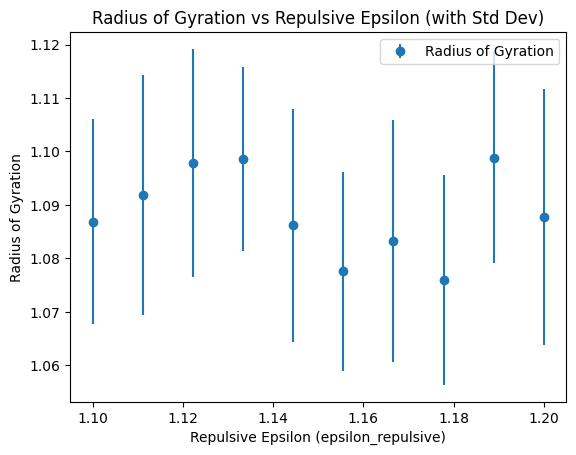

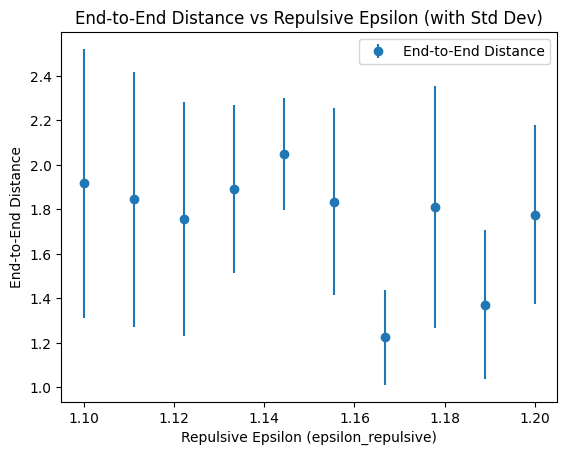

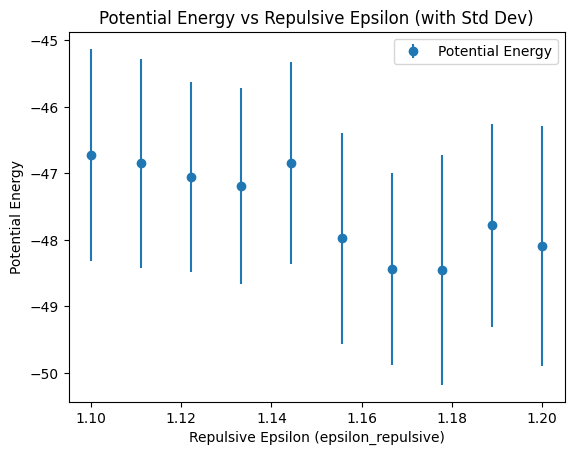

In [6]:
# Epsilon range for the simulation
epsilon_repulsive_values = np.linspace(1.1, 1.2, 10)

# Arrays to store results for different epsilon values
mean_Rg_values = []
std_Rg_values = []
mean_Ree_values = []
std_Ree_values = []
mean_potential_energies = []
std_potential_energies = []

# Loop over each epsilon_repulsive
for epsilon_repulsive in epsilon_repulsive_values:
    # Initialize positions and velocities with ASE
    polymer_chain = initialize_chain_ase(n_particles, box_size, r0)
    positions = polymer_chain.get_positions()
    velocities = initialize_velocities(n_particles, target_temperature, mass)
    forces = compute_harmonic_forces(positions, k, r0, box_size) + compute_lennard_jones_forces(positions, box_size, epsilon_repulsive)

    # Equilibration phase
    for step in range(equilibration_steps):
        positions, velocities, forces = velocity_verlet(positions, velocities, forces, dt, mass, box_size, epsilon_repulsive)
        polymer_chain.set_positions(positions)
        if step % rescale_interval == 0:
            velocities = rescale_velocities(velocities, target_temperature, mass)

    # Sampling phase
    Rg_values = []
    Ree_values = []
    potential_energies = []
    trajectories = []

    for step in range(sampling_steps):
        positions, velocities, forces = velocity_verlet(positions, velocities, forces, dt, mass, box_size, epsilon_repulsive)
        polymer_chain.set_positions(positions)  # Update ASE positions
        if step % rescale_interval == 0:
            velocities = rescale_velocities(velocities, target_temperature, mass)

        # Compute properties
        Rg = calculate_radius_of_gyration(positions)
        Ree = calculate_end_to_end_distance(positions)

        # Calculate potential energy
        E_harmonic = 0.0
        for i in range(n_particles - 1):
            displacement = positions[i + 1] - positions[i]
            displacement = minimum_image(displacement, box_size)
            distance = np.linalg.norm(displacement)
            E_harmonic += 0.5 * k * (distance - r0)**2

        E_LJ = 0.0
        for i in range(len(positions) - 1):
            for j in range(i + 1, len(positions)):
                displacement = positions[j] - positions[i]
                displacement = minimum_image(displacement, box_size)
                distance = np.linalg.norm(displacement)
                if distance < cutoff or distance == 0:
                    continue  # Ignore interactions beyond the cutoff or zero distance
                if abs(i - j) == 2:
                    epsilon_value = epsilon_repulsive
                elif abs(i - j) > 2:
                    epsilon_value = epsilon_attractive
                else:
                    continue
                E_LJ += 4 * epsilon_value * ((sigma / distance)**12 - (sigma / distance)**6)

        potential_energy = E_harmonic + E_LJ

        # Store results
        Rg_values.append(Rg)
        Ree_values.append(Ree)
        potential_energies.append(potential_energy)
        trajectories.append(positions.copy())

    # Convert lists to NumPy arrays
    Rg_values = np.array(Rg_values)
    Ree_values = np.array(Ree_values)
    potential_energies = np.array(potential_energies)
    trajectories = np.array(trajectories)

    # Save the trajectory data for the current epsilon value
    trajectory_file_path = os.path.join(output_dir, f"trajectories_epsilon_{epsilon_repulsive:.2f}.npy")
    np.save(trajectory_file_path, trajectories)
    print(f"Trajectories for epsilon_repulsive {epsilon_repulsive:.2f} saved to: {trajectory_file_path}")

    # Calculate mean and standard deviation for the current epsilon value
    mean_Rg_values.append(np.mean(Rg_values))
    std_Rg_values.append(np.std(Rg_values))

    mean_Ree_values.append(np.mean(Ree_values))
    std_Ree_values.append(np.std(Ree_values))

    mean_potential_energies.append(np.mean(potential_energies))
    std_potential_energies.append(np.std(potential_energies))

# Plotting the results with standard deviation
plt.figure()
plt.errorbar(epsilon_repulsive_values, mean_Rg_values, yerr=std_Rg_values, fmt='o', label='Radius of Gyration')
plt.xlabel('Repulsive Epsilon (epsilon_repulsive)')
plt.ylabel('Radius of Gyration')
plt.title('Radius of Gyration vs Repulsive Epsilon (with Std Dev)')
plt.legend()
plt.show()

plt.figure()
plt.errorbar(epsilon_repulsive_values, mean_Ree_values, yerr=std_Ree_values, fmt='o', label='End-to-End Distance')
plt.xlabel('Repulsive Epsilon (epsilon_repulsive)')
plt.ylabel('End-to-End Distance')
plt.title('End-to-End Distance vs Repulsive Epsilon (with Std Dev)')
plt.legend()
plt.show()

plt.figure()
plt.errorbar(epsilon_repulsive_values, mean_potential_energies, yerr=std_potential_energies, fmt='o', label='Potential Energy')
plt.xlabel('Repulsive Epsilon (epsilon_repulsive)')
plt.ylabel('Potential Energy')
plt.title('Potential Energy vs Repulsive Epsilon (with Std Dev)')
plt.legend()
plt.show()


In [7]:
# Print results for Radius of Gyration
print("Repulsive Epsilon vs Radius of Gyration")
print(f"{'Epsilon_Repulsive':>18} {'Mean Rg':>10} {'Std Rg':>10}")
for epsilon, mean_Rg, std_Rg in zip(epsilon_repulsive_values, mean_Rg_values, std_Rg_values):
    print(f"{epsilon:18.4f} {mean_Rg:10.4f} {std_Rg:10.4f}")

print("\nRepulsive Epsilon vs End-to-End Distance")
print(f"{'Epsilon_Repulsive':>18} {'Mean Ree':>10} {'Std Ree':>10}")
for epsilon, mean_Ree, std_Ree in zip(epsilon_repulsive_values, mean_Ree_values, std_Ree_values):
    print(f"{epsilon:18.4f} {mean_Ree:10.4f} {std_Ree:10.4f}")

print("\nRepulsive Epsilon vs Potential Energy")
print(f"{'Epsilon_Repulsive':>18} {'Mean PE':>10} {'Std PE':>10}")
for epsilon, mean_PE, std_PE in zip(epsilon_repulsive_values, mean_potential_energies, std_potential_energies):
    print(f"{epsilon:18.4f} {mean_PE:10.4f} {std_PE:10.4f}")


Repulsive Epsilon vs Radius of Gyration
 Epsilon_Repulsive    Mean Rg     Std Rg
            1.1000     1.0869     0.0192
            1.1111     1.0918     0.0225
            1.1222     1.0979     0.0213
            1.1333     1.0986     0.0173
            1.1444     1.0861     0.0219
            1.1556     1.0776     0.0187
            1.1667     1.0833     0.0227
            1.1778     1.0760     0.0196
            1.1889     1.0988     0.0197
            1.2000     1.0877     0.0239

Repulsive Epsilon vs End-to-End Distance
 Epsilon_Repulsive   Mean Ree    Std Ree
            1.1000     1.9167     0.6050
            1.1111     1.8446     0.5746
            1.1222     1.7551     0.5257
            1.1333     1.8919     0.3775
            1.1444     2.0498     0.2513
            1.1556     1.8350     0.4187
            1.1667     1.2237     0.2126
            1.1778     1.8090     0.5434
            1.1889     1.3708     0.3355
            1.2000     1.7749     0.4022

Repulsive Epsil

Trajectories for epsilon_repulsive 1.20 saved to: C:\Users\khh38\Desktop\PhD\Class\comp-prob-solv\Project_2\trajectories_output\trajectories_epsilon_1.20.npy
Trajectories for epsilon_repulsive 1.21 saved to: C:\Users\khh38\Desktop\PhD\Class\comp-prob-solv\Project_2\trajectories_output\trajectories_epsilon_1.21.npy
Trajectories for epsilon_repulsive 1.22 saved to: C:\Users\khh38\Desktop\PhD\Class\comp-prob-solv\Project_2\trajectories_output\trajectories_epsilon_1.22.npy
Trajectories for epsilon_repulsive 1.23 saved to: C:\Users\khh38\Desktop\PhD\Class\comp-prob-solv\Project_2\trajectories_output\trajectories_epsilon_1.23.npy
Trajectories for epsilon_repulsive 1.24 saved to: C:\Users\khh38\Desktop\PhD\Class\comp-prob-solv\Project_2\trajectories_output\trajectories_epsilon_1.24.npy
Trajectories for epsilon_repulsive 1.26 saved to: C:\Users\khh38\Desktop\PhD\Class\comp-prob-solv\Project_2\trajectories_output\trajectories_epsilon_1.26.npy
Trajectories for epsilon_repulsive 1.27 saved to: C:

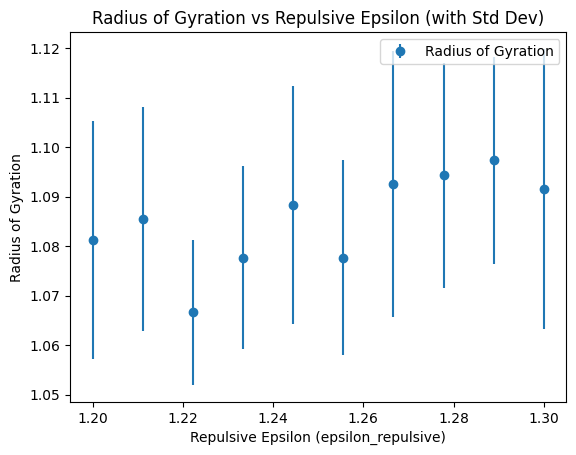

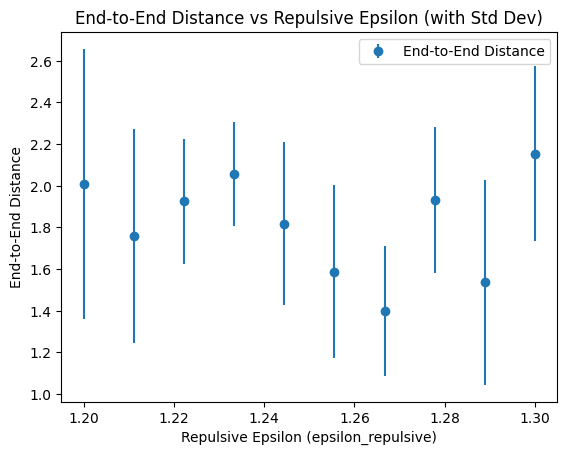

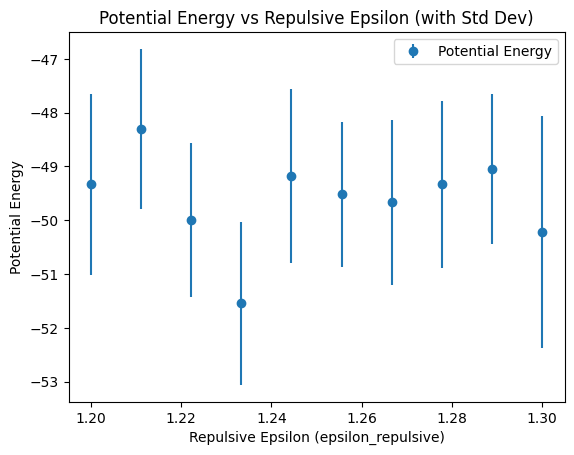

In [8]:
# Epsilon range for the simulation
epsilon_repulsive_values = np.linspace(1.2, 1.3, 10)

# Arrays to store results for different epsilon values
mean_Rg_values = []
std_Rg_values = []
mean_Ree_values = []
std_Ree_values = []
mean_potential_energies = []
std_potential_energies = []

# Loop over each epsilon_repulsive
for epsilon_repulsive in epsilon_repulsive_values:
    # Initialize positions and velocities with ASE
    polymer_chain = initialize_chain_ase(n_particles, box_size, r0)
    positions = polymer_chain.get_positions()
    velocities = initialize_velocities(n_particles, target_temperature, mass)
    forces = compute_harmonic_forces(positions, k, r0, box_size) + compute_lennard_jones_forces(positions, box_size, epsilon_repulsive)

    # Equilibration phase
    for step in range(equilibration_steps):
        positions, velocities, forces = velocity_verlet(positions, velocities, forces, dt, mass, box_size, epsilon_repulsive)
        polymer_chain.set_positions(positions)
        if step % rescale_interval == 0:
            velocities = rescale_velocities(velocities, target_temperature, mass)

    # Sampling phase
    Rg_values = []
    Ree_values = []
    potential_energies = []
    trajectories = []

    for step in range(sampling_steps):
        positions, velocities, forces = velocity_verlet(positions, velocities, forces, dt, mass, box_size, epsilon_repulsive)
        polymer_chain.set_positions(positions)  # Update ASE positions
        if step % rescale_interval == 0:
            velocities = rescale_velocities(velocities, target_temperature, mass)

        # Compute properties
        Rg = calculate_radius_of_gyration(positions)
        Ree = calculate_end_to_end_distance(positions)

        # Calculate potential energy
        E_harmonic = 0.0
        for i in range(n_particles - 1):
            displacement = positions[i + 1] - positions[i]
            displacement = minimum_image(displacement, box_size)
            distance = np.linalg.norm(displacement)
            E_harmonic += 0.5 * k * (distance - r0)**2

        E_LJ = 0.0
        for i in range(len(positions) - 1):
            for j in range(i + 1, len(positions)):
                displacement = positions[j] - positions[i]
                displacement = minimum_image(displacement, box_size)
                distance = np.linalg.norm(displacement)
                if distance < cutoff or distance == 0:
                    continue  # Ignore interactions beyond the cutoff or zero distance
                if abs(i - j) == 2:
                    epsilon_value = epsilon_repulsive
                elif abs(i - j) > 2:
                    epsilon_value = epsilon_attractive
                else:
                    continue
                E_LJ += 4 * epsilon_value * ((sigma / distance)**12 - (sigma / distance)**6)

        potential_energy = E_harmonic + E_LJ

        # Store results
        Rg_values.append(Rg)
        Ree_values.append(Ree)
        potential_energies.append(potential_energy)
        trajectories.append(positions.copy())

    # Convert lists to NumPy arrays
    Rg_values = np.array(Rg_values)
    Ree_values = np.array(Ree_values)
    potential_energies = np.array(potential_energies)
    trajectories = np.array(trajectories)

    # Save the trajectory data for the current epsilon value
    trajectory_file_path = os.path.join(output_dir, f"trajectories_epsilon_{epsilon_repulsive:.2f}.npy")
    np.save(trajectory_file_path, trajectories)
    print(f"Trajectories for epsilon_repulsive {epsilon_repulsive:.2f} saved to: {trajectory_file_path}")

    # Calculate mean and standard deviation for the current epsilon value
    mean_Rg_values.append(np.mean(Rg_values))
    std_Rg_values.append(np.std(Rg_values))

    mean_Ree_values.append(np.mean(Ree_values))
    std_Ree_values.append(np.std(Ree_values))

    mean_potential_energies.append(np.mean(potential_energies))
    std_potential_energies.append(np.std(potential_energies))

# Plotting the results with standard deviation
plt.figure()
plt.errorbar(epsilon_repulsive_values, mean_Rg_values, yerr=std_Rg_values, fmt='o', label='Radius of Gyration')
plt.xlabel('Repulsive Epsilon (epsilon_repulsive)')
plt.ylabel('Radius of Gyration')
plt.title('Radius of Gyration vs Repulsive Epsilon (with Std Dev)')
plt.legend()
plt.show()

plt.figure()
plt.errorbar(epsilon_repulsive_values, mean_Ree_values, yerr=std_Ree_values, fmt='o', label='End-to-End Distance')
plt.xlabel('Repulsive Epsilon (epsilon_repulsive)')
plt.ylabel('End-to-End Distance')
plt.title('End-to-End Distance vs Repulsive Epsilon (with Std Dev)')
plt.legend()
plt.show()

plt.figure()
plt.errorbar(epsilon_repulsive_values, mean_potential_energies, yerr=std_potential_energies, fmt='o', label='Potential Energy')
plt.xlabel('Repulsive Epsilon (epsilon_repulsive)')
plt.ylabel('Potential Energy')
plt.title('Potential Energy vs Repulsive Epsilon (with Std Dev)')
plt.legend()
plt.show()


In [9]:
# Print results for Radius of Gyration
print("Repulsive Epsilon vs Radius of Gyration")
print(f"{'Epsilon_Repulsive':>18} {'Mean Rg':>10} {'Std Rg':>10}")
for epsilon, mean_Rg, std_Rg in zip(epsilon_repulsive_values, mean_Rg_values, std_Rg_values):
    print(f"{epsilon:18.4f} {mean_Rg:10.4f} {std_Rg:10.4f}")

print("\nRepulsive Epsilon vs End-to-End Distance")
print(f"{'Epsilon_Repulsive':>18} {'Mean Ree':>10} {'Std Ree':>10}")
for epsilon, mean_Ree, std_Ree in zip(epsilon_repulsive_values, mean_Ree_values, std_Ree_values):
    print(f"{epsilon:18.4f} {mean_Ree:10.4f} {std_Ree:10.4f}")

print("\nRepulsive Epsilon vs Potential Energy")
print(f"{'Epsilon_Repulsive':>18} {'Mean PE':>10} {'Std PE':>10}")
for epsilon, mean_PE, std_PE in zip(epsilon_repulsive_values, mean_potential_energies, std_potential_energies):
    print(f"{epsilon:18.4f} {mean_PE:10.4f} {std_PE:10.4f}")


Repulsive Epsilon vs Radius of Gyration
 Epsilon_Repulsive    Mean Rg     Std Rg
            1.2000     1.0813     0.0241
            1.2111     1.0855     0.0226
            1.2222     1.0666     0.0146
            1.2333     1.0777     0.0185
            1.2444     1.0883     0.0241
            1.2556     1.0777     0.0198
            1.2667     1.0925     0.0268
            1.2778     1.0943     0.0227
            1.2889     1.0973     0.0209
            1.3000     1.0915     0.0283

Repulsive Epsilon vs End-to-End Distance
 Epsilon_Repulsive   Mean Ree    Std Ree
            1.2000     2.0084     0.6487
            1.2111     1.7570     0.5128
            1.2222     1.9241     0.2985
            1.2333     2.0569     0.2504
            1.2444     1.8169     0.3912
            1.2556     1.5875     0.4167
            1.2667     1.3999     0.3115
            1.2778     1.9329     0.3509
            1.2889     1.5359     0.4916
            1.3000     2.1540     0.4205

Repulsive Epsil

Trajectories for epsilon_repulsive 1.30 saved to: C:\Users\khh38\Desktop\PhD\Class\comp-prob-solv\Project_2\trajectories_output\trajectories_epsilon_1.30.npy
Trajectories for epsilon_repulsive 1.31 saved to: C:\Users\khh38\Desktop\PhD\Class\comp-prob-solv\Project_2\trajectories_output\trajectories_epsilon_1.31.npy
Trajectories for epsilon_repulsive 1.32 saved to: C:\Users\khh38\Desktop\PhD\Class\comp-prob-solv\Project_2\trajectories_output\trajectories_epsilon_1.32.npy
Trajectories for epsilon_repulsive 1.33 saved to: C:\Users\khh38\Desktop\PhD\Class\comp-prob-solv\Project_2\trajectories_output\trajectories_epsilon_1.33.npy
Trajectories for epsilon_repulsive 1.34 saved to: C:\Users\khh38\Desktop\PhD\Class\comp-prob-solv\Project_2\trajectories_output\trajectories_epsilon_1.34.npy
Trajectories for epsilon_repulsive 1.36 saved to: C:\Users\khh38\Desktop\PhD\Class\comp-prob-solv\Project_2\trajectories_output\trajectories_epsilon_1.36.npy
Trajectories for epsilon_repulsive 1.37 saved to: C:

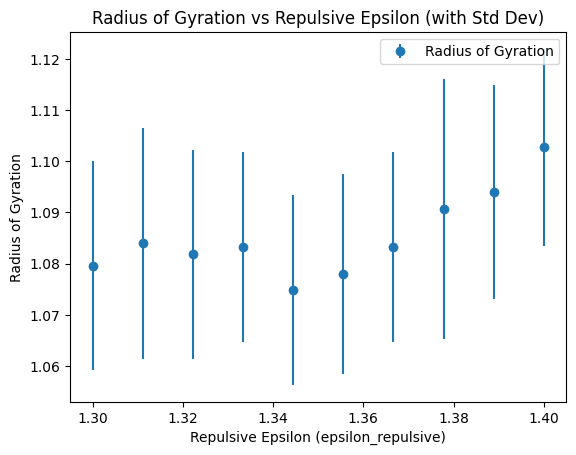

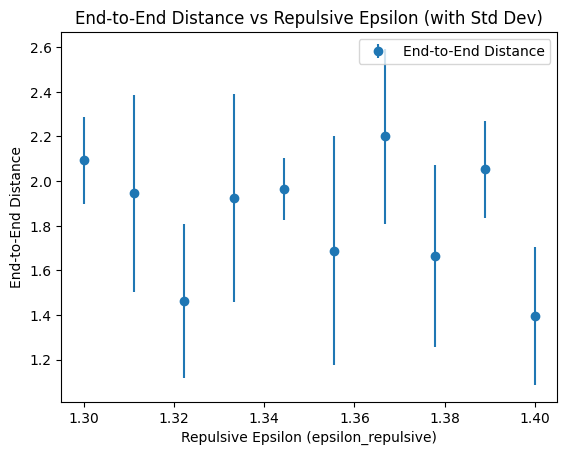

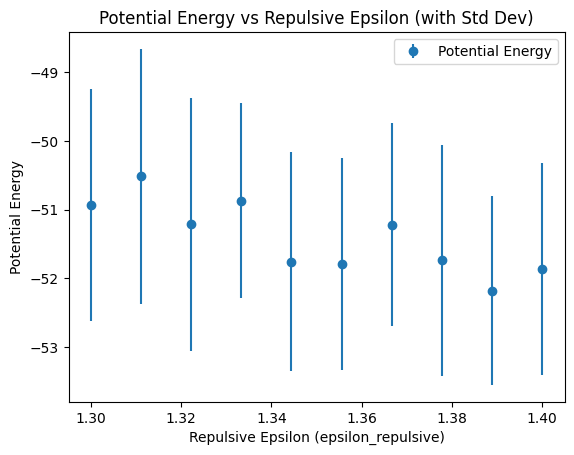

In [10]:
# Epsilon range for the simulation
epsilon_repulsive_values = np.linspace(1.3, 1.4, 10)

# Arrays to store results for different epsilon values
mean_Rg_values = []
std_Rg_values = []
mean_Ree_values = []
std_Ree_values = []
mean_potential_energies = []
std_potential_energies = []

# Loop over each epsilon_repulsive
for epsilon_repulsive in epsilon_repulsive_values:
    # Initialize positions and velocities with ASE
    polymer_chain = initialize_chain_ase(n_particles, box_size, r0)
    positions = polymer_chain.get_positions()
    velocities = initialize_velocities(n_particles, target_temperature, mass)
    forces = compute_harmonic_forces(positions, k, r0, box_size) + compute_lennard_jones_forces(positions, box_size, epsilon_repulsive)

    # Equilibration phase
    for step in range(equilibration_steps):
        positions, velocities, forces = velocity_verlet(positions, velocities, forces, dt, mass, box_size, epsilon_repulsive)
        polymer_chain.set_positions(positions)
        if step % rescale_interval == 0:
            velocities = rescale_velocities(velocities, target_temperature, mass)

    # Sampling phase
    Rg_values = []
    Ree_values = []
    potential_energies = []
    trajectories = []

    for step in range(sampling_steps):
        positions, velocities, forces = velocity_verlet(positions, velocities, forces, dt, mass, box_size, epsilon_repulsive)
        polymer_chain.set_positions(positions)  # Update ASE positions
        if step % rescale_interval == 0:
            velocities = rescale_velocities(velocities, target_temperature, mass)

        # Compute properties
        Rg = calculate_radius_of_gyration(positions)
        Ree = calculate_end_to_end_distance(positions)

        # Calculate potential energy
        E_harmonic = 0.0
        for i in range(n_particles - 1):
            displacement = positions[i + 1] - positions[i]
            displacement = minimum_image(displacement, box_size)
            distance = np.linalg.norm(displacement)
            E_harmonic += 0.5 * k * (distance - r0)**2

        E_LJ = 0.0
        for i in range(len(positions) - 1):
            for j in range(i + 1, len(positions)):
                displacement = positions[j] - positions[i]
                displacement = minimum_image(displacement, box_size)
                distance = np.linalg.norm(displacement)
                if distance < cutoff or distance == 0:
                    continue  # Ignore interactions beyond the cutoff or zero distance
                if abs(i - j) == 2:
                    epsilon_value = epsilon_repulsive
                elif abs(i - j) > 2:
                    epsilon_value = epsilon_attractive
                else:
                    continue
                E_LJ += 4 * epsilon_value * ((sigma / distance)**12 - (sigma / distance)**6)

        potential_energy = E_harmonic + E_LJ

        # Store results
        Rg_values.append(Rg)
        Ree_values.append(Ree)
        potential_energies.append(potential_energy)
        trajectories.append(positions.copy())

    # Convert lists to NumPy arrays
    Rg_values = np.array(Rg_values)
    Ree_values = np.array(Ree_values)
    potential_energies = np.array(potential_energies)
    trajectories = np.array(trajectories)

    # Save the trajectory data for the current epsilon value
    trajectory_file_path = os.path.join(output_dir, f"trajectories_epsilon_{epsilon_repulsive:.2f}.npy")
    np.save(trajectory_file_path, trajectories)
    print(f"Trajectories for epsilon_repulsive {epsilon_repulsive:.2f} saved to: {trajectory_file_path}")

    # Calculate mean and standard deviation for the current epsilon value
    mean_Rg_values.append(np.mean(Rg_values))
    std_Rg_values.append(np.std(Rg_values))

    mean_Ree_values.append(np.mean(Ree_values))
    std_Ree_values.append(np.std(Ree_values))

    mean_potential_energies.append(np.mean(potential_energies))
    std_potential_energies.append(np.std(potential_energies))

# Plotting the results with standard deviation
plt.figure()
plt.errorbar(epsilon_repulsive_values, mean_Rg_values, yerr=std_Rg_values, fmt='o', label='Radius of Gyration')
plt.xlabel('Repulsive Epsilon (epsilon_repulsive)')
plt.ylabel('Radius of Gyration')
plt.title('Radius of Gyration vs Repulsive Epsilon (with Std Dev)')
plt.legend()
plt.show()

plt.figure()
plt.errorbar(epsilon_repulsive_values, mean_Ree_values, yerr=std_Ree_values, fmt='o', label='End-to-End Distance')
plt.xlabel('Repulsive Epsilon (epsilon_repulsive)')
plt.ylabel('End-to-End Distance')
plt.title('End-to-End Distance vs Repulsive Epsilon (with Std Dev)')
plt.legend()
plt.show()

plt.figure()
plt.errorbar(epsilon_repulsive_values, mean_potential_energies, yerr=std_potential_energies, fmt='o', label='Potential Energy')
plt.xlabel('Repulsive Epsilon (epsilon_repulsive)')
plt.ylabel('Potential Energy')
plt.title('Potential Energy vs Repulsive Epsilon (with Std Dev)')
plt.legend()
plt.show()


In [11]:
# Print results for Radius of Gyration
print("Repulsive Epsilon vs Radius of Gyration")
print(f"{'Epsilon_Repulsive':>18} {'Mean Rg':>10} {'Std Rg':>10}")
for epsilon, mean_Rg, std_Rg in zip(epsilon_repulsive_values, mean_Rg_values, std_Rg_values):
    print(f"{epsilon:18.4f} {mean_Rg:10.4f} {std_Rg:10.4f}")

print("\nRepulsive Epsilon vs End-to-End Distance")
print(f"{'Epsilon_Repulsive':>18} {'Mean Ree':>10} {'Std Ree':>10}")
for epsilon, mean_Ree, std_Ree in zip(epsilon_repulsive_values, mean_Ree_values, std_Ree_values):
    print(f"{epsilon:18.4f} {mean_Ree:10.4f} {std_Ree:10.4f}")

print("\nRepulsive Epsilon vs Potential Energy")
print(f"{'Epsilon_Repulsive':>18} {'Mean PE':>10} {'Std PE':>10}")
for epsilon, mean_PE, std_PE in zip(epsilon_repulsive_values, mean_potential_energies, std_potential_energies):
    print(f"{epsilon:18.4f} {mean_PE:10.4f} {std_PE:10.4f}")


Repulsive Epsilon vs Radius of Gyration
 Epsilon_Repulsive    Mean Rg     Std Rg
            1.3000     1.0796     0.0204
            1.3111     1.0839     0.0225
            1.3222     1.0818     0.0204
            1.3333     1.0832     0.0185
            1.3444     1.0748     0.0185
            1.3556     1.0779     0.0195
            1.3667     1.0832     0.0186
            1.3778     1.0906     0.0254
            1.3889     1.0939     0.0209
            1.4000     1.1027     0.0192

Repulsive Epsilon vs End-to-End Distance
 Epsilon_Repulsive   Mean Ree    Std Ree
            1.3000     2.0932     0.1943
            1.3111     1.9448     0.4411
            1.3222     1.4627     0.3471
            1.3333     1.9244     0.4677
            1.3444     1.9647     0.1407
            1.3556     1.6875     0.5129
            1.3667     2.2005     0.3922
            1.3778     1.6642     0.4057
            1.3889     2.0529     0.2171
            1.4000     1.3949     0.3075

Repulsive Epsil

Trajectories for epsilon_repulsive 1.40 saved to: C:\Users\khh38\Desktop\PhD\Class\comp-prob-solv\Project_2\trajectories_output\trajectories_epsilon_1.40.npy
Trajectories for epsilon_repulsive 1.41 saved to: C:\Users\khh38\Desktop\PhD\Class\comp-prob-solv\Project_2\trajectories_output\trajectories_epsilon_1.41.npy
Trajectories for epsilon_repulsive 1.42 saved to: C:\Users\khh38\Desktop\PhD\Class\comp-prob-solv\Project_2\trajectories_output\trajectories_epsilon_1.42.npy
Trajectories for epsilon_repulsive 1.43 saved to: C:\Users\khh38\Desktop\PhD\Class\comp-prob-solv\Project_2\trajectories_output\trajectories_epsilon_1.43.npy
Trajectories for epsilon_repulsive 1.44 saved to: C:\Users\khh38\Desktop\PhD\Class\comp-prob-solv\Project_2\trajectories_output\trajectories_epsilon_1.44.npy
Trajectories for epsilon_repulsive 1.46 saved to: C:\Users\khh38\Desktop\PhD\Class\comp-prob-solv\Project_2\trajectories_output\trajectories_epsilon_1.46.npy
Trajectories for epsilon_repulsive 1.47 saved to: C:

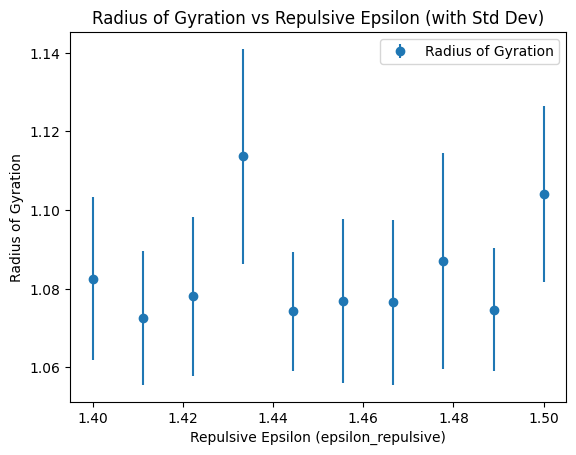

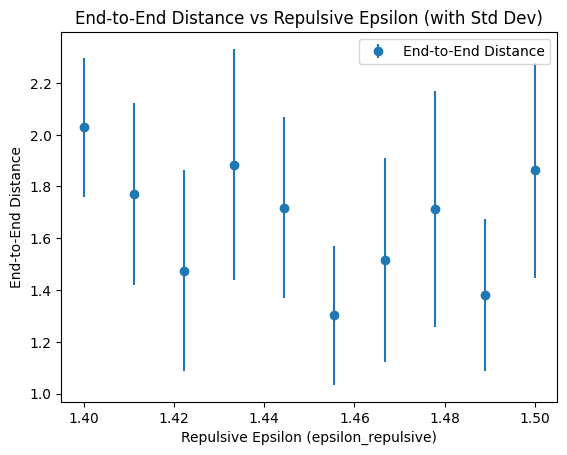

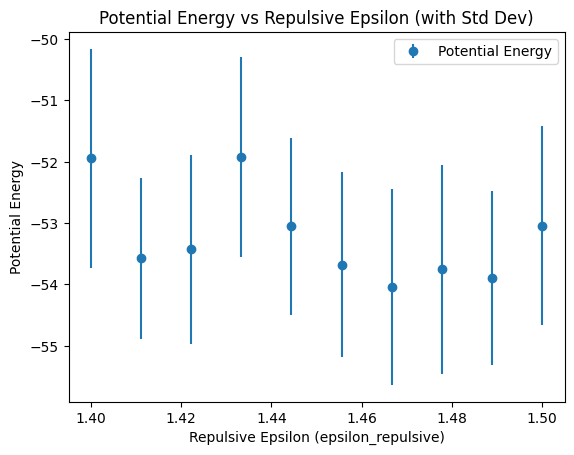

In [12]:
# Epsilon range for the simulation
epsilon_repulsive_values = np.linspace(1.4, 1.5, 10)

# Arrays to store results for different epsilon values
mean_Rg_values = []
std_Rg_values = []
mean_Ree_values = []
std_Ree_values = []
mean_potential_energies = []
std_potential_energies = []

# Loop over each epsilon_repulsive
for epsilon_repulsive in epsilon_repulsive_values:
    # Initialize positions and velocities with ASE
    polymer_chain = initialize_chain_ase(n_particles, box_size, r0)
    positions = polymer_chain.get_positions()
    velocities = initialize_velocities(n_particles, target_temperature, mass)
    forces = compute_harmonic_forces(positions, k, r0, box_size) + compute_lennard_jones_forces(positions, box_size, epsilon_repulsive)

    # Equilibration phase
    for step in range(equilibration_steps):
        positions, velocities, forces = velocity_verlet(positions, velocities, forces, dt, mass, box_size, epsilon_repulsive)
        polymer_chain.set_positions(positions)
        if step % rescale_interval == 0:
            velocities = rescale_velocities(velocities, target_temperature, mass)

    # Sampling phase
    Rg_values = []
    Ree_values = []
    potential_energies = []
    trajectories = []

    for step in range(sampling_steps):
        positions, velocities, forces = velocity_verlet(positions, velocities, forces, dt, mass, box_size, epsilon_repulsive)
        polymer_chain.set_positions(positions)  # Update ASE positions
        if step % rescale_interval == 0:
            velocities = rescale_velocities(velocities, target_temperature, mass)

        # Compute properties
        Rg = calculate_radius_of_gyration(positions)
        Ree = calculate_end_to_end_distance(positions)

        # Calculate potential energy
        E_harmonic = 0.0
        for i in range(n_particles - 1):
            displacement = positions[i + 1] - positions[i]
            displacement = minimum_image(displacement, box_size)
            distance = np.linalg.norm(displacement)
            E_harmonic += 0.5 * k * (distance - r0)**2

        E_LJ = 0.0
        for i in range(len(positions) - 1):
            for j in range(i + 1, len(positions)):
                displacement = positions[j] - positions[i]
                displacement = minimum_image(displacement, box_size)
                distance = np.linalg.norm(displacement)
                if distance < cutoff or distance == 0:
                    continue  # Ignore interactions beyond the cutoff or zero distance
                if abs(i - j) == 2:
                    epsilon_value = epsilon_repulsive
                elif abs(i - j) > 2:
                    epsilon_value = epsilon_attractive
                else:
                    continue
                E_LJ += 4 * epsilon_value * ((sigma / distance)**12 - (sigma / distance)**6)

        potential_energy = E_harmonic + E_LJ

        # Store results
        Rg_values.append(Rg)
        Ree_values.append(Ree)
        potential_energies.append(potential_energy)
        trajectories.append(positions.copy())

    # Convert lists to NumPy arrays
    Rg_values = np.array(Rg_values)
    Ree_values = np.array(Ree_values)
    potential_energies = np.array(potential_energies)
    trajectories = np.array(trajectories)

    # Save the trajectory data for the current epsilon value
    trajectory_file_path = os.path.join(output_dir, f"trajectories_epsilon_{epsilon_repulsive:.2f}.npy")
    np.save(trajectory_file_path, trajectories)
    print(f"Trajectories for epsilon_repulsive {epsilon_repulsive:.2f} saved to: {trajectory_file_path}")

    # Calculate mean and standard deviation for the current epsilon value
    mean_Rg_values.append(np.mean(Rg_values))
    std_Rg_values.append(np.std(Rg_values))

    mean_Ree_values.append(np.mean(Ree_values))
    std_Ree_values.append(np.std(Ree_values))

    mean_potential_energies.append(np.mean(potential_energies))
    std_potential_energies.append(np.std(potential_energies))

# Plotting the results with standard deviation
plt.figure()
plt.errorbar(epsilon_repulsive_values, mean_Rg_values, yerr=std_Rg_values, fmt='o', label='Radius of Gyration')
plt.xlabel('Repulsive Epsilon (epsilon_repulsive)')
plt.ylabel('Radius of Gyration')
plt.title('Radius of Gyration vs Repulsive Epsilon (with Std Dev)')
plt.legend()
plt.show()

plt.figure()
plt.errorbar(epsilon_repulsive_values, mean_Ree_values, yerr=std_Ree_values, fmt='o', label='End-to-End Distance')
plt.xlabel('Repulsive Epsilon (epsilon_repulsive)')
plt.ylabel('End-to-End Distance')
plt.title('End-to-End Distance vs Repulsive Epsilon (with Std Dev)')
plt.legend()
plt.show()

plt.figure()
plt.errorbar(epsilon_repulsive_values, mean_potential_energies, yerr=std_potential_energies, fmt='o', label='Potential Energy')
plt.xlabel('Repulsive Epsilon (epsilon_repulsive)')
plt.ylabel('Potential Energy')
plt.title('Potential Energy vs Repulsive Epsilon (with Std Dev)')
plt.legend()
plt.show()


In [13]:
# Print results for Radius of Gyration
print("Repulsive Epsilon vs Radius of Gyration")
print(f"{'Epsilon_Repulsive':>18} {'Mean Rg':>10} {'Std Rg':>10}")
for epsilon, mean_Rg, std_Rg in zip(epsilon_repulsive_values, mean_Rg_values, std_Rg_values):
    print(f"{epsilon:18.4f} {mean_Rg:10.4f} {std_Rg:10.4f}")

print("\nRepulsive Epsilon vs End-to-End Distance")
print(f"{'Epsilon_Repulsive':>18} {'Mean Ree':>10} {'Std Ree':>10}")
for epsilon, mean_Ree, std_Ree in zip(epsilon_repulsive_values, mean_Ree_values, std_Ree_values):
    print(f"{epsilon:18.4f} {mean_Ree:10.4f} {std_Ree:10.4f}")

print("\nRepulsive Epsilon vs Potential Energy")
print(f"{'Epsilon_Repulsive':>18} {'Mean PE':>10} {'Std PE':>10}")
for epsilon, mean_PE, std_PE in zip(epsilon_repulsive_values, mean_potential_energies, std_potential_energies):
    print(f"{epsilon:18.4f} {mean_PE:10.4f} {std_PE:10.4f}")


Repulsive Epsilon vs Radius of Gyration
 Epsilon_Repulsive    Mean Rg     Std Rg
            1.4000     1.0826     0.0208
            1.4111     1.0726     0.0170
            1.4222     1.0781     0.0202
            1.4333     1.1137     0.0273
            1.4444     1.0742     0.0151
            1.4556     1.0769     0.0208
            1.4667     1.0765     0.0209
            1.4778     1.0871     0.0275
            1.4889     1.0747     0.0155
            1.5000     1.1041     0.0224

Repulsive Epsilon vs End-to-End Distance
 Epsilon_Repulsive   Mean Ree    Std Ree
            1.4000     2.0292     0.2683
            1.4111     1.7698     0.3520
            1.4222     1.4749     0.3872
            1.4333     1.8845     0.4474
            1.4444     1.7181     0.3503
            1.4556     1.3024     0.2684
            1.4667     1.5155     0.3944
            1.4778     1.7138     0.4549
            1.4889     1.3811     0.2938
            1.5000     1.8630     0.4156

Repulsive Epsil

Trajectories for epsilon_repulsive 1.50 saved to: C:\Users\khh38\Desktop\PhD\Class\comp-prob-solv\Project_2\trajectories_output\trajectories_epsilon_1.50.npy
Trajectories for epsilon_repulsive 1.51 saved to: C:\Users\khh38\Desktop\PhD\Class\comp-prob-solv\Project_2\trajectories_output\trajectories_epsilon_1.51.npy
Trajectories for epsilon_repulsive 1.52 saved to: C:\Users\khh38\Desktop\PhD\Class\comp-prob-solv\Project_2\trajectories_output\trajectories_epsilon_1.52.npy
Trajectories for epsilon_repulsive 1.53 saved to: C:\Users\khh38\Desktop\PhD\Class\comp-prob-solv\Project_2\trajectories_output\trajectories_epsilon_1.53.npy
Trajectories for epsilon_repulsive 1.54 saved to: C:\Users\khh38\Desktop\PhD\Class\comp-prob-solv\Project_2\trajectories_output\trajectories_epsilon_1.54.npy
Trajectories for epsilon_repulsive 1.55 saved to: C:\Users\khh38\Desktop\PhD\Class\comp-prob-solv\Project_2\trajectories_output\trajectories_epsilon_1.55.npy
Trajectories for epsilon_repulsive 1.56 saved to: C:

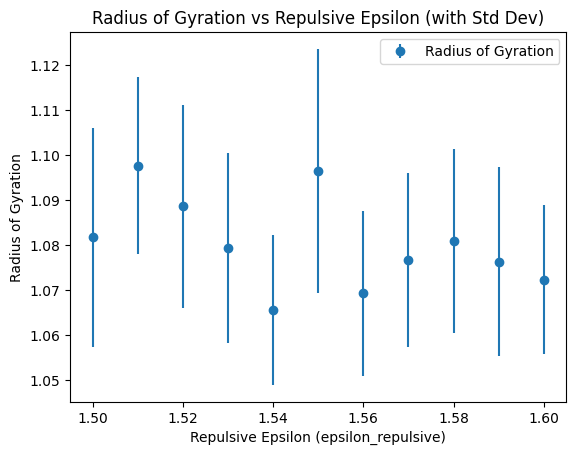

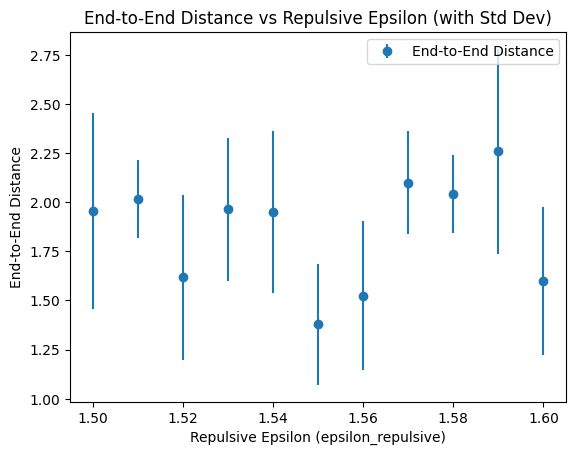

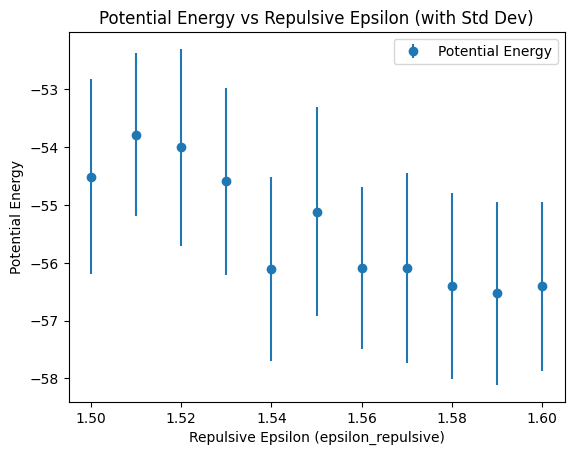

In [16]:
# Epsilon range for the simulation
epsilon_repulsive_values = np.linspace(1.5, 1.6, 11)

# Arrays to store results for different epsilon values
mean_Rg_values = []
std_Rg_values = []
mean_Ree_values = []
std_Ree_values = []
mean_potential_energies = []
std_potential_energies = []

# Loop over each epsilon_repulsive
for epsilon_repulsive in epsilon_repulsive_values:
    # Initialize positions and velocities with ASE
    polymer_chain = initialize_chain_ase(n_particles, box_size, r0)
    positions = polymer_chain.get_positions()
    velocities = initialize_velocities(n_particles, target_temperature, mass)
    forces = compute_harmonic_forces(positions, k, r0, box_size) + compute_lennard_jones_forces(positions, box_size, epsilon_repulsive)

    # Equilibration phase
    for step in range(equilibration_steps):
        positions, velocities, forces = velocity_verlet(positions, velocities, forces, dt, mass, box_size, epsilon_repulsive)
        polymer_chain.set_positions(positions)
        if step % rescale_interval == 0:
            velocities = rescale_velocities(velocities, target_temperature, mass)

    # Sampling phase
    Rg_values = []
    Ree_values = []
    potential_energies = []
    trajectories = []

    for step in range(sampling_steps):
        positions, velocities, forces = velocity_verlet(positions, velocities, forces, dt, mass, box_size, epsilon_repulsive)
        polymer_chain.set_positions(positions)  # Update ASE positions
        if step % rescale_interval == 0:
            velocities = rescale_velocities(velocities, target_temperature, mass)

        # Compute properties
        Rg = calculate_radius_of_gyration(positions)
        Ree = calculate_end_to_end_distance(positions)

        # Calculate potential energy
        E_harmonic = 0.0
        for i in range(n_particles - 1):
            displacement = positions[i + 1] - positions[i]
            displacement = minimum_image(displacement, box_size)
            distance = np.linalg.norm(displacement)
            E_harmonic += 0.5 * k * (distance - r0)**2

        E_LJ = 0.0
        for i in range(len(positions) - 1):
            for j in range(i + 1, len(positions)):
                displacement = positions[j] - positions[i]
                displacement = minimum_image(displacement, box_size)
                distance = np.linalg.norm(displacement)
                if distance < cutoff or distance == 0:
                    continue  # Ignore interactions beyond the cutoff or zero distance
                if abs(i - j) == 2:
                    epsilon_value = epsilon_repulsive
                elif abs(i - j) > 2:
                    epsilon_value = epsilon_attractive
                else:
                    continue
                E_LJ += 4 * epsilon_value * ((sigma / distance)**12 - (sigma / distance)**6)

        potential_energy = E_harmonic + E_LJ

        # Store results
        Rg_values.append(Rg)
        Ree_values.append(Ree)
        potential_energies.append(potential_energy)
        trajectories.append(positions.copy())

    # Convert lists to NumPy arrays
    Rg_values = np.array(Rg_values)
    Ree_values = np.array(Ree_values)
    potential_energies = np.array(potential_energies)
    trajectories = np.array(trajectories)

    # Save the trajectory data for the current epsilon value
    trajectory_file_path = os.path.join(output_dir, f"trajectories_epsilon_{epsilon_repulsive:.2f}.npy")
    np.save(trajectory_file_path, trajectories)
    print(f"Trajectories for epsilon_repulsive {epsilon_repulsive:.2f} saved to: {trajectory_file_path}")

    # Calculate mean and standard deviation for the current epsilon value
    mean_Rg_values.append(np.mean(Rg_values))
    std_Rg_values.append(np.std(Rg_values))

    mean_Ree_values.append(np.mean(Ree_values))
    std_Ree_values.append(np.std(Ree_values))

    mean_potential_energies.append(np.mean(potential_energies))
    std_potential_energies.append(np.std(potential_energies))

# Plotting the results with standard deviation
plt.figure()
plt.errorbar(epsilon_repulsive_values, mean_Rg_values, yerr=std_Rg_values, fmt='o', label='Radius of Gyration')
plt.xlabel('Repulsive Epsilon (epsilon_repulsive)')
plt.ylabel('Radius of Gyration')
plt.title('Radius of Gyration vs Repulsive Epsilon (with Std Dev)')
plt.legend()
plt.show()

plt.figure()
plt.errorbar(epsilon_repulsive_values, mean_Ree_values, yerr=std_Ree_values, fmt='o', label='End-to-End Distance')
plt.xlabel('Repulsive Epsilon (epsilon_repulsive)')
plt.ylabel('End-to-End Distance')
plt.title('End-to-End Distance vs Repulsive Epsilon (with Std Dev)')
plt.legend()
plt.show()

plt.figure()
plt.errorbar(epsilon_repulsive_values, mean_potential_energies, yerr=std_potential_energies, fmt='o', label='Potential Energy')
plt.xlabel('Repulsive Epsilon (epsilon_repulsive)')
plt.ylabel('Potential Energy')
plt.title('Potential Energy vs Repulsive Epsilon (with Std Dev)')
plt.legend()
plt.show()


In [17]:
# Print results for Radius of Gyration
print("Repulsive Epsilon vs Radius of Gyration")
print(f"{'Epsilon_Repulsive':>18} {'Mean Rg':>10} {'Std Rg':>10}")
for epsilon, mean_Rg, std_Rg in zip(epsilon_repulsive_values, mean_Rg_values, std_Rg_values):
    print(f"{epsilon:18.4f} {mean_Rg:10.4f} {std_Rg:10.4f}")

print("\nRepulsive Epsilon vs End-to-End Distance")
print(f"{'Epsilon_Repulsive':>18} {'Mean Ree':>10} {'Std Ree':>10}")
for epsilon, mean_Ree, std_Ree in zip(epsilon_repulsive_values, mean_Ree_values, std_Ree_values):
    print(f"{epsilon:18.4f} {mean_Ree:10.4f} {std_Ree:10.4f}")

print("\nRepulsive Epsilon vs Potential Energy")
print(f"{'Epsilon_Repulsive':>18} {'Mean PE':>10} {'Std PE':>10}")
for epsilon, mean_PE, std_PE in zip(epsilon_repulsive_values, mean_potential_energies, std_potential_energies):
    print(f"{epsilon:18.4f} {mean_PE:10.4f} {std_PE:10.4f}")


Repulsive Epsilon vs Radius of Gyration
 Epsilon_Repulsive    Mean Rg     Std Rg
            1.5000     1.0817     0.0244
            1.5100     1.0976     0.0196
            1.5200     1.0886     0.0225
            1.5300     1.0794     0.0211
            1.5400     1.0656     0.0166
            1.5500     1.0964     0.0271
            1.5600     1.0693     0.0183
            1.5700     1.0767     0.0193
            1.5800     1.0808     0.0205
            1.5900     1.0763     0.0210
            1.6000     1.0723     0.0165

Repulsive Epsilon vs End-to-End Distance
 Epsilon_Repulsive   Mean Ree    Std Ree
            1.5000     1.9537     0.4995
            1.5100     2.0159     0.1977
            1.5200     1.6191     0.4204
            1.5300     1.9634     0.3640
            1.5400     1.9513     0.4131
            1.5500     1.3784     0.3077
            1.5600     1.5244     0.3793
            1.5700     2.0997     0.2634
            1.5800     2.0435     0.1983
            1.59

Trajectories for epsilon_repulsive 1.60 saved to: C:\Users\khh38\Desktop\PhD\Class\comp-prob-solv\Project_2\trajectories_output\trajectories_epsilon_1.60.npy
Trajectories for epsilon_repulsive 1.61 saved to: C:\Users\khh38\Desktop\PhD\Class\comp-prob-solv\Project_2\trajectories_output\trajectories_epsilon_1.61.npy
Trajectories for epsilon_repulsive 1.62 saved to: C:\Users\khh38\Desktop\PhD\Class\comp-prob-solv\Project_2\trajectories_output\trajectories_epsilon_1.62.npy
Trajectories for epsilon_repulsive 1.63 saved to: C:\Users\khh38\Desktop\PhD\Class\comp-prob-solv\Project_2\trajectories_output\trajectories_epsilon_1.63.npy
Trajectories for epsilon_repulsive 1.64 saved to: C:\Users\khh38\Desktop\PhD\Class\comp-prob-solv\Project_2\trajectories_output\trajectories_epsilon_1.64.npy
Trajectories for epsilon_repulsive 1.65 saved to: C:\Users\khh38\Desktop\PhD\Class\comp-prob-solv\Project_2\trajectories_output\trajectories_epsilon_1.65.npy
Trajectories for epsilon_repulsive 1.66 saved to: C:

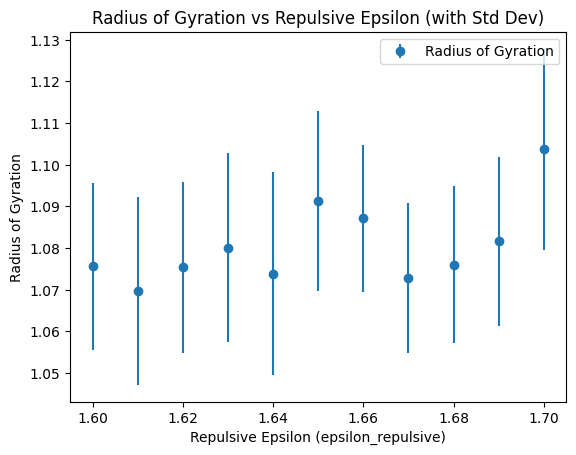

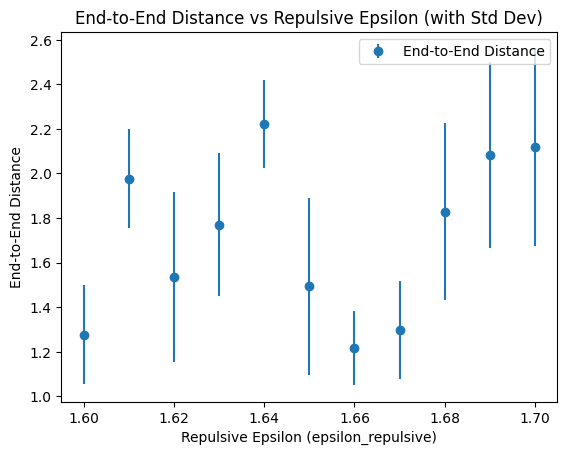

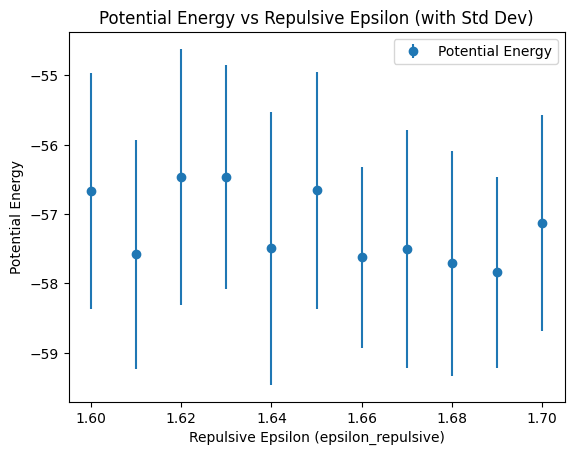

In [18]:
# Epsilon range for the simulation
epsilon_repulsive_values = np.linspace(1.6, 1.7, 11)

# Arrays to store results for different epsilon values
mean_Rg_values = []
std_Rg_values = []
mean_Ree_values = []
std_Ree_values = []
mean_potential_energies = []
std_potential_energies = []

# Loop over each epsilon_repulsive
for epsilon_repulsive in epsilon_repulsive_values:
    # Initialize positions and velocities with ASE
    polymer_chain = initialize_chain_ase(n_particles, box_size, r0)
    positions = polymer_chain.get_positions()
    velocities = initialize_velocities(n_particles, target_temperature, mass)
    forces = compute_harmonic_forces(positions, k, r0, box_size) + compute_lennard_jones_forces(positions, box_size, epsilon_repulsive)

    # Equilibration phase
    for step in range(equilibration_steps):
        positions, velocities, forces = velocity_verlet(positions, velocities, forces, dt, mass, box_size, epsilon_repulsive)
        polymer_chain.set_positions(positions)
        if step % rescale_interval == 0:
            velocities = rescale_velocities(velocities, target_temperature, mass)

    # Sampling phase
    Rg_values = []
    Ree_values = []
    potential_energies = []
    trajectories = []

    for step in range(sampling_steps):
        positions, velocities, forces = velocity_verlet(positions, velocities, forces, dt, mass, box_size, epsilon_repulsive)
        polymer_chain.set_positions(positions)  # Update ASE positions
        if step % rescale_interval == 0:
            velocities = rescale_velocities(velocities, target_temperature, mass)

        # Compute properties
        Rg = calculate_radius_of_gyration(positions)
        Ree = calculate_end_to_end_distance(positions)

        # Calculate potential energy
        E_harmonic = 0.0
        for i in range(n_particles - 1):
            displacement = positions[i + 1] - positions[i]
            displacement = minimum_image(displacement, box_size)
            distance = np.linalg.norm(displacement)
            E_harmonic += 0.5 * k * (distance - r0)**2

        E_LJ = 0.0
        for i in range(len(positions) - 1):
            for j in range(i + 1, len(positions)):
                displacement = positions[j] - positions[i]
                displacement = minimum_image(displacement, box_size)
                distance = np.linalg.norm(displacement)
                if distance < cutoff or distance == 0:
                    continue  # Ignore interactions beyond the cutoff or zero distance
                if abs(i - j) == 2:
                    epsilon_value = epsilon_repulsive
                elif abs(i - j) > 2:
                    epsilon_value = epsilon_attractive
                else:
                    continue
                E_LJ += 4 * epsilon_value * ((sigma / distance)**12 - (sigma / distance)**6)

        potential_energy = E_harmonic + E_LJ

        # Store results
        Rg_values.append(Rg)
        Ree_values.append(Ree)
        potential_energies.append(potential_energy)
        trajectories.append(positions.copy())

    # Convert lists to NumPy arrays
    Rg_values = np.array(Rg_values)
    Ree_values = np.array(Ree_values)
    potential_energies = np.array(potential_energies)
    trajectories = np.array(trajectories)

    # Save the trajectory data for the current epsilon value
    trajectory_file_path = os.path.join(output_dir, f"trajectories_epsilon_{epsilon_repulsive:.2f}.npy")
    np.save(trajectory_file_path, trajectories)
    print(f"Trajectories for epsilon_repulsive {epsilon_repulsive:.2f} saved to: {trajectory_file_path}")

    # Calculate mean and standard deviation for the current epsilon value
    mean_Rg_values.append(np.mean(Rg_values))
    std_Rg_values.append(np.std(Rg_values))

    mean_Ree_values.append(np.mean(Ree_values))
    std_Ree_values.append(np.std(Ree_values))

    mean_potential_energies.append(np.mean(potential_energies))
    std_potential_energies.append(np.std(potential_energies))

# Plotting the results with standard deviation
plt.figure()
plt.errorbar(epsilon_repulsive_values, mean_Rg_values, yerr=std_Rg_values, fmt='o', label='Radius of Gyration')
plt.xlabel('Repulsive Epsilon (epsilon_repulsive)')
plt.ylabel('Radius of Gyration')
plt.title('Radius of Gyration vs Repulsive Epsilon (with Std Dev)')
plt.legend()
plt.show()

plt.figure()
plt.errorbar(epsilon_repulsive_values, mean_Ree_values, yerr=std_Ree_values, fmt='o', label='End-to-End Distance')
plt.xlabel('Repulsive Epsilon (epsilon_repulsive)')
plt.ylabel('End-to-End Distance')
plt.title('End-to-End Distance vs Repulsive Epsilon (with Std Dev)')
plt.legend()
plt.show()

plt.figure()
plt.errorbar(epsilon_repulsive_values, mean_potential_energies, yerr=std_potential_energies, fmt='o', label='Potential Energy')
plt.xlabel('Repulsive Epsilon (epsilon_repulsive)')
plt.ylabel('Potential Energy')
plt.title('Potential Energy vs Repulsive Epsilon (with Std Dev)')
plt.legend()
plt.show()


In [19]:
# Print results for Radius of Gyration
print("Repulsive Epsilon vs Radius of Gyration")
print(f"{'Epsilon_Repulsive':>18} {'Mean Rg':>10} {'Std Rg':>10}")
for epsilon, mean_Rg, std_Rg in zip(epsilon_repulsive_values, mean_Rg_values, std_Rg_values):
    print(f"{epsilon:18.4f} {mean_Rg:10.4f} {std_Rg:10.4f}")

print("\nRepulsive Epsilon vs End-to-End Distance")
print(f"{'Epsilon_Repulsive':>18} {'Mean Ree':>10} {'Std Ree':>10}")
for epsilon, mean_Ree, std_Ree in zip(epsilon_repulsive_values, mean_Ree_values, std_Ree_values):
    print(f"{epsilon:18.4f} {mean_Ree:10.4f} {std_Ree:10.4f}")

print("\nRepulsive Epsilon vs Potential Energy")
print(f"{'Epsilon_Repulsive':>18} {'Mean PE':>10} {'Std PE':>10}")
for epsilon, mean_PE, std_PE in zip(epsilon_repulsive_values, mean_potential_energies, std_potential_energies):
    print(f"{epsilon:18.4f} {mean_PE:10.4f} {std_PE:10.4f}")


Repulsive Epsilon vs Radius of Gyration
 Epsilon_Repulsive    Mean Rg     Std Rg
            1.6000     1.0756     0.0200
            1.6100     1.0697     0.0226
            1.6200     1.0753     0.0205
            1.6300     1.0801     0.0227
            1.6400     1.0738     0.0244
            1.6500     1.0913     0.0216
            1.6600     1.0871     0.0177
            1.6700     1.0728     0.0180
            1.6800     1.0760     0.0188
            1.6900     1.0816     0.0203
            1.7000     1.1037     0.0242

Repulsive Epsilon vs End-to-End Distance
 Epsilon_Repulsive   Mean Ree    Std Ree
            1.6000     1.2766     0.2209
            1.6100     1.9768     0.2235
            1.6200     1.5357     0.3832
            1.6300     1.7703     0.3198
            1.6400     2.2228     0.1970
            1.6500     1.4929     0.3955
            1.6600     1.2176     0.1655
            1.6700     1.2996     0.2197
            1.6800     1.8280     0.3968
            1.69

Trajectories for epsilon_repulsive 1.70 saved to: C:\Users\khh38\Desktop\PhD\Class\comp-prob-solv\Project_2\trajectories_output\trajectories_epsilon_1.70.npy
Trajectories for epsilon_repulsive 1.71 saved to: C:\Users\khh38\Desktop\PhD\Class\comp-prob-solv\Project_2\trajectories_output\trajectories_epsilon_1.71.npy
Trajectories for epsilon_repulsive 1.72 saved to: C:\Users\khh38\Desktop\PhD\Class\comp-prob-solv\Project_2\trajectories_output\trajectories_epsilon_1.72.npy
Trajectories for epsilon_repulsive 1.73 saved to: C:\Users\khh38\Desktop\PhD\Class\comp-prob-solv\Project_2\trajectories_output\trajectories_epsilon_1.73.npy
Trajectories for epsilon_repulsive 1.74 saved to: C:\Users\khh38\Desktop\PhD\Class\comp-prob-solv\Project_2\trajectories_output\trajectories_epsilon_1.74.npy
Trajectories for epsilon_repulsive 1.75 saved to: C:\Users\khh38\Desktop\PhD\Class\comp-prob-solv\Project_2\trajectories_output\trajectories_epsilon_1.75.npy
Trajectories for epsilon_repulsive 1.76 saved to: C:

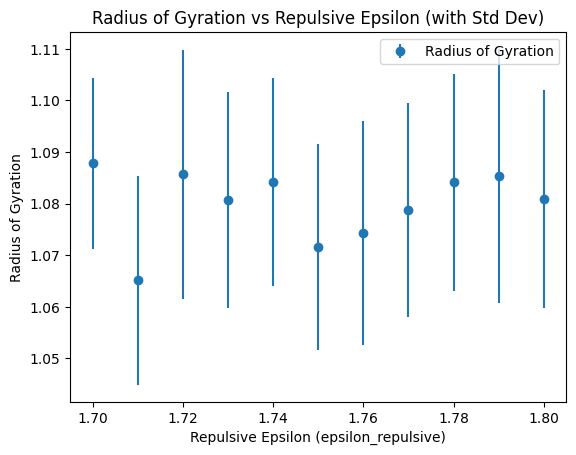

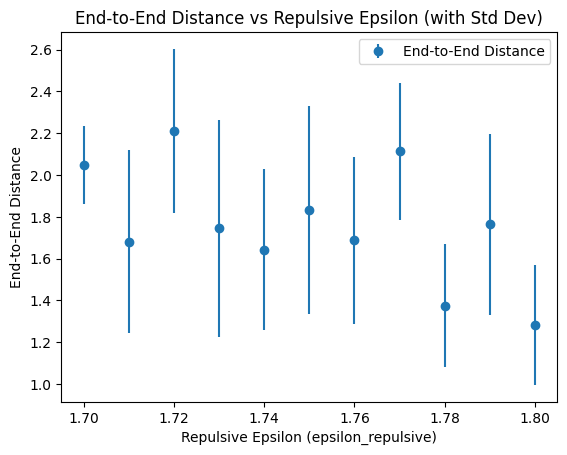

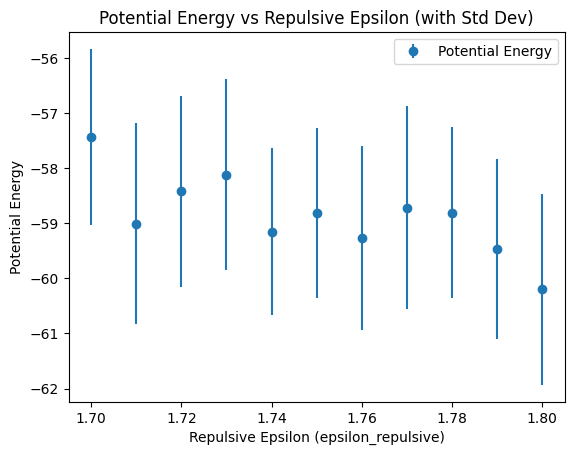

In [20]:
# Epsilon range for the simulation
epsilon_repulsive_values = np.linspace(1.7, 1.8, 11)

# Arrays to store results for different epsilon values
mean_Rg_values = []
std_Rg_values = []
mean_Ree_values = []
std_Ree_values = []
mean_potential_energies = []
std_potential_energies = []

# Loop over each epsilon_repulsive
for epsilon_repulsive in epsilon_repulsive_values:
    # Initialize positions and velocities with ASE
    polymer_chain = initialize_chain_ase(n_particles, box_size, r0)
    positions = polymer_chain.get_positions()
    velocities = initialize_velocities(n_particles, target_temperature, mass)
    forces = compute_harmonic_forces(positions, k, r0, box_size) + compute_lennard_jones_forces(positions, box_size, epsilon_repulsive)

    # Equilibration phase
    for step in range(equilibration_steps):
        positions, velocities, forces = velocity_verlet(positions, velocities, forces, dt, mass, box_size, epsilon_repulsive)
        polymer_chain.set_positions(positions)
        if step % rescale_interval == 0:
            velocities = rescale_velocities(velocities, target_temperature, mass)

    # Sampling phase
    Rg_values = []
    Ree_values = []
    potential_energies = []
    trajectories = []

    for step in range(sampling_steps):
        positions, velocities, forces = velocity_verlet(positions, velocities, forces, dt, mass, box_size, epsilon_repulsive)
        polymer_chain.set_positions(positions)  # Update ASE positions
        if step % rescale_interval == 0:
            velocities = rescale_velocities(velocities, target_temperature, mass)

        # Compute properties
        Rg = calculate_radius_of_gyration(positions)
        Ree = calculate_end_to_end_distance(positions)

        # Calculate potential energy
        E_harmonic = 0.0
        for i in range(n_particles - 1):
            displacement = positions[i + 1] - positions[i]
            displacement = minimum_image(displacement, box_size)
            distance = np.linalg.norm(displacement)
            E_harmonic += 0.5 * k * (distance - r0)**2

        E_LJ = 0.0
        for i in range(len(positions) - 1):
            for j in range(i + 1, len(positions)):
                displacement = positions[j] - positions[i]
                displacement = minimum_image(displacement, box_size)
                distance = np.linalg.norm(displacement)
                if distance < cutoff or distance == 0:
                    continue  # Ignore interactions beyond the cutoff or zero distance
                if abs(i - j) == 2:
                    epsilon_value = epsilon_repulsive
                elif abs(i - j) > 2:
                    epsilon_value = epsilon_attractive
                else:
                    continue
                E_LJ += 4 * epsilon_value * ((sigma / distance)**12 - (sigma / distance)**6)

        potential_energy = E_harmonic + E_LJ

        # Store results
        Rg_values.append(Rg)
        Ree_values.append(Ree)
        potential_energies.append(potential_energy)
        trajectories.append(positions.copy())

    # Convert lists to NumPy arrays
    Rg_values = np.array(Rg_values)
    Ree_values = np.array(Ree_values)
    potential_energies = np.array(potential_energies)
    trajectories = np.array(trajectories)

    # Save the trajectory data for the current epsilon value
    trajectory_file_path = os.path.join(output_dir, f"trajectories_epsilon_{epsilon_repulsive:.2f}.npy")
    np.save(trajectory_file_path, trajectories)
    print(f"Trajectories for epsilon_repulsive {epsilon_repulsive:.2f} saved to: {trajectory_file_path}")

    # Calculate mean and standard deviation for the current epsilon value
    mean_Rg_values.append(np.mean(Rg_values))
    std_Rg_values.append(np.std(Rg_values))

    mean_Ree_values.append(np.mean(Ree_values))
    std_Ree_values.append(np.std(Ree_values))

    mean_potential_energies.append(np.mean(potential_energies))
    std_potential_energies.append(np.std(potential_energies))

# Plotting the results with standard deviation
plt.figure()
plt.errorbar(epsilon_repulsive_values, mean_Rg_values, yerr=std_Rg_values, fmt='o', label='Radius of Gyration')
plt.xlabel('Repulsive Epsilon (epsilon_repulsive)')
plt.ylabel('Radius of Gyration')
plt.title('Radius of Gyration vs Repulsive Epsilon (with Std Dev)')
plt.legend()
plt.show()

plt.figure()
plt.errorbar(epsilon_repulsive_values, mean_Ree_values, yerr=std_Ree_values, fmt='o', label='End-to-End Distance')
plt.xlabel('Repulsive Epsilon (epsilon_repulsive)')
plt.ylabel('End-to-End Distance')
plt.title('End-to-End Distance vs Repulsive Epsilon (with Std Dev)')
plt.legend()
plt.show()

plt.figure()
plt.errorbar(epsilon_repulsive_values, mean_potential_energies, yerr=std_potential_energies, fmt='o', label='Potential Energy')
plt.xlabel('Repulsive Epsilon (epsilon_repulsive)')
plt.ylabel('Potential Energy')
plt.title('Potential Energy vs Repulsive Epsilon (with Std Dev)')
plt.legend()
plt.show()


In [21]:
# Print results for Radius of Gyration
print("Repulsive Epsilon vs Radius of Gyration")
print(f"{'Epsilon_Repulsive':>18} {'Mean Rg':>10} {'Std Rg':>10}")
for epsilon, mean_Rg, std_Rg in zip(epsilon_repulsive_values, mean_Rg_values, std_Rg_values):
    print(f"{epsilon:18.4f} {mean_Rg:10.4f} {std_Rg:10.4f}")

print("\nRepulsive Epsilon vs End-to-End Distance")
print(f"{'Epsilon_Repulsive':>18} {'Mean Ree':>10} {'Std Ree':>10}")
for epsilon, mean_Ree, std_Ree in zip(epsilon_repulsive_values, mean_Ree_values, std_Ree_values):
    print(f"{epsilon:18.4f} {mean_Ree:10.4f} {std_Ree:10.4f}")

print("\nRepulsive Epsilon vs Potential Energy")
print(f"{'Epsilon_Repulsive':>18} {'Mean PE':>10} {'Std PE':>10}")
for epsilon, mean_PE, std_PE in zip(epsilon_repulsive_values, mean_potential_energies, std_potential_energies):
    print(f"{epsilon:18.4f} {mean_PE:10.4f} {std_PE:10.4f}")


Repulsive Epsilon vs Radius of Gyration
 Epsilon_Repulsive    Mean Rg     Std Rg
            1.7000     1.0878     0.0166
            1.7100     1.0651     0.0202
            1.7200     1.0856     0.0242
            1.7300     1.0807     0.0209
            1.7400     1.0841     0.0202
            1.7500     1.0716     0.0199
            1.7600     1.0743     0.0217
            1.7700     1.0788     0.0208
            1.7800     1.0841     0.0211
            1.7900     1.0854     0.0246
            1.8000     1.0808     0.0211

Repulsive Epsilon vs End-to-End Distance
 Epsilon_Repulsive   Mean Ree    Std Ree
            1.7000     2.0471     0.1864
            1.7100     1.6814     0.4370
            1.7200     2.2110     0.3928
            1.7300     1.7450     0.5195
            1.7400     1.6422     0.3858
            1.7500     1.8322     0.4968
            1.7600     1.6871     0.3999
            1.7700     2.1130     0.3284
            1.7800     1.3758     0.2948
            1.79

Trajectories for epsilon_repulsive 1.80 saved to: C:\Users\khh38\Desktop\PhD\Class\comp-prob-solv\Project_2\trajectories_output\trajectories_epsilon_1.80.npy
Trajectories for epsilon_repulsive 1.81 saved to: C:\Users\khh38\Desktop\PhD\Class\comp-prob-solv\Project_2\trajectories_output\trajectories_epsilon_1.81.npy
Trajectories for epsilon_repulsive 1.82 saved to: C:\Users\khh38\Desktop\PhD\Class\comp-prob-solv\Project_2\trajectories_output\trajectories_epsilon_1.82.npy
Trajectories for epsilon_repulsive 1.83 saved to: C:\Users\khh38\Desktop\PhD\Class\comp-prob-solv\Project_2\trajectories_output\trajectories_epsilon_1.83.npy
Trajectories for epsilon_repulsive 1.84 saved to: C:\Users\khh38\Desktop\PhD\Class\comp-prob-solv\Project_2\trajectories_output\trajectories_epsilon_1.84.npy
Trajectories for epsilon_repulsive 1.85 saved to: C:\Users\khh38\Desktop\PhD\Class\comp-prob-solv\Project_2\trajectories_output\trajectories_epsilon_1.85.npy
Trajectories for epsilon_repulsive 1.86 saved to: C:

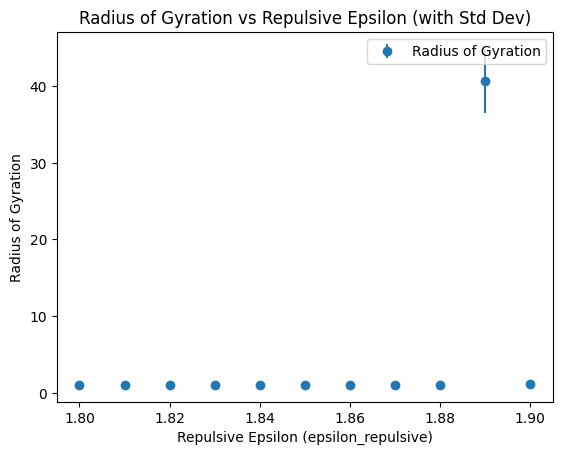

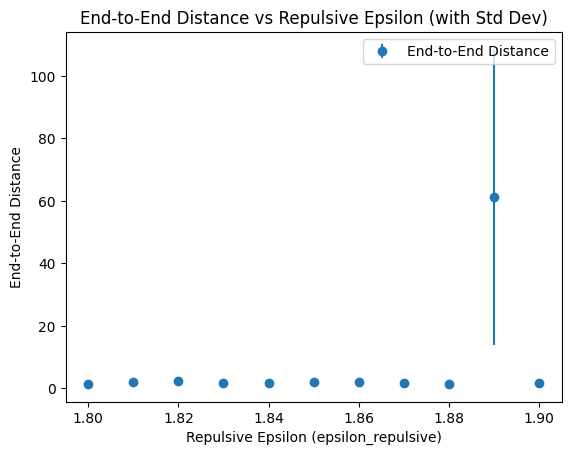

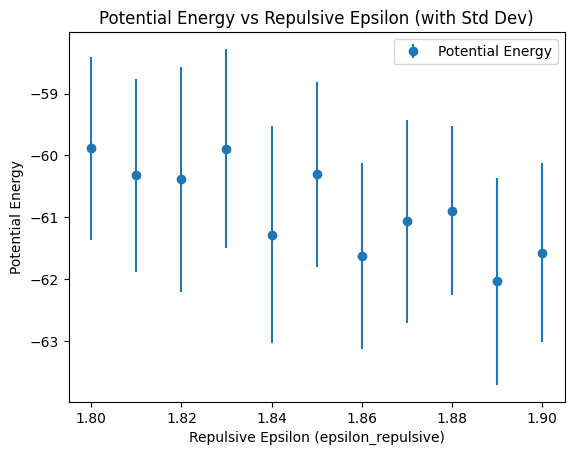

In [22]:
# Epsilon range for the simulation
epsilon_repulsive_values = np.linspace(1.8, 1.9, 11)

# Arrays to store results for different epsilon values
mean_Rg_values = []
std_Rg_values = []
mean_Ree_values = []
std_Ree_values = []
mean_potential_energies = []
std_potential_energies = []

# Loop over each epsilon_repulsive
for epsilon_repulsive in epsilon_repulsive_values:
    # Initialize positions and velocities with ASE
    polymer_chain = initialize_chain_ase(n_particles, box_size, r0)
    positions = polymer_chain.get_positions()
    velocities = initialize_velocities(n_particles, target_temperature, mass)
    forces = compute_harmonic_forces(positions, k, r0, box_size) + compute_lennard_jones_forces(positions, box_size, epsilon_repulsive)

    # Equilibration phase
    for step in range(equilibration_steps):
        positions, velocities, forces = velocity_verlet(positions, velocities, forces, dt, mass, box_size, epsilon_repulsive)
        polymer_chain.set_positions(positions)
        if step % rescale_interval == 0:
            velocities = rescale_velocities(velocities, target_temperature, mass)

    # Sampling phase
    Rg_values = []
    Ree_values = []
    potential_energies = []
    trajectories = []

    for step in range(sampling_steps):
        positions, velocities, forces = velocity_verlet(positions, velocities, forces, dt, mass, box_size, epsilon_repulsive)
        polymer_chain.set_positions(positions)  # Update ASE positions
        if step % rescale_interval == 0:
            velocities = rescale_velocities(velocities, target_temperature, mass)

        # Compute properties
        Rg = calculate_radius_of_gyration(positions)
        Ree = calculate_end_to_end_distance(positions)

        # Calculate potential energy
        E_harmonic = 0.0
        for i in range(n_particles - 1):
            displacement = positions[i + 1] - positions[i]
            displacement = minimum_image(displacement, box_size)
            distance = np.linalg.norm(displacement)
            E_harmonic += 0.5 * k * (distance - r0)**2

        E_LJ = 0.0
        for i in range(len(positions) - 1):
            for j in range(i + 1, len(positions)):
                displacement = positions[j] - positions[i]
                displacement = minimum_image(displacement, box_size)
                distance = np.linalg.norm(displacement)
                if distance < cutoff or distance == 0:
                    continue  # Ignore interactions beyond the cutoff or zero distance
                if abs(i - j) == 2:
                    epsilon_value = epsilon_repulsive
                elif abs(i - j) > 2:
                    epsilon_value = epsilon_attractive
                else:
                    continue
                E_LJ += 4 * epsilon_value * ((sigma / distance)**12 - (sigma / distance)**6)

        potential_energy = E_harmonic + E_LJ

        # Store results
        Rg_values.append(Rg)
        Ree_values.append(Ree)
        potential_energies.append(potential_energy)
        trajectories.append(positions.copy())

    # Convert lists to NumPy arrays
    Rg_values = np.array(Rg_values)
    Ree_values = np.array(Ree_values)
    potential_energies = np.array(potential_energies)
    trajectories = np.array(trajectories)

    # Save the trajectory data for the current epsilon value
    trajectory_file_path = os.path.join(output_dir, f"trajectories_epsilon_{epsilon_repulsive:.2f}.npy")
    np.save(trajectory_file_path, trajectories)
    print(f"Trajectories for epsilon_repulsive {epsilon_repulsive:.2f} saved to: {trajectory_file_path}")

    # Calculate mean and standard deviation for the current epsilon value
    mean_Rg_values.append(np.mean(Rg_values))
    std_Rg_values.append(np.std(Rg_values))

    mean_Ree_values.append(np.mean(Ree_values))
    std_Ree_values.append(np.std(Ree_values))

    mean_potential_energies.append(np.mean(potential_energies))
    std_potential_energies.append(np.std(potential_energies))

# Plotting the results with standard deviation
plt.figure()
plt.errorbar(epsilon_repulsive_values, mean_Rg_values, yerr=std_Rg_values, fmt='o', label='Radius of Gyration')
plt.xlabel('Repulsive Epsilon (epsilon_repulsive)')
plt.ylabel('Radius of Gyration')
plt.title('Radius of Gyration vs Repulsive Epsilon (with Std Dev)')
plt.legend()
plt.show()

plt.figure()
plt.errorbar(epsilon_repulsive_values, mean_Ree_values, yerr=std_Ree_values, fmt='o', label='End-to-End Distance')
plt.xlabel('Repulsive Epsilon (epsilon_repulsive)')
plt.ylabel('End-to-End Distance')
plt.title('End-to-End Distance vs Repulsive Epsilon (with Std Dev)')
plt.legend()
plt.show()

plt.figure()
plt.errorbar(epsilon_repulsive_values, mean_potential_energies, yerr=std_potential_energies, fmt='o', label='Potential Energy')
plt.xlabel('Repulsive Epsilon (epsilon_repulsive)')
plt.ylabel('Potential Energy')
plt.title('Potential Energy vs Repulsive Epsilon (with Std Dev)')
plt.legend()
plt.show()


In [23]:
# Print results for Radius of Gyration
print("Repulsive Epsilon vs Radius of Gyration")
print(f"{'Epsilon_Repulsive':>18} {'Mean Rg':>10} {'Std Rg':>10}")
for epsilon, mean_Rg, std_Rg in zip(epsilon_repulsive_values, mean_Rg_values, std_Rg_values):
    print(f"{epsilon:18.4f} {mean_Rg:10.4f} {std_Rg:10.4f}")

print("\nRepulsive Epsilon vs End-to-End Distance")
print(f"{'Epsilon_Repulsive':>18} {'Mean Ree':>10} {'Std Ree':>10}")
for epsilon, mean_Ree, std_Ree in zip(epsilon_repulsive_values, mean_Ree_values, std_Ree_values):
    print(f"{epsilon:18.4f} {mean_Ree:10.4f} {std_Ree:10.4f}")

print("\nRepulsive Epsilon vs Potential Energy")
print(f"{'Epsilon_Repulsive':>18} {'Mean PE':>10} {'Std PE':>10}")
for epsilon, mean_PE, std_PE in zip(epsilon_repulsive_values, mean_potential_energies, std_potential_energies):
    print(f"{epsilon:18.4f} {mean_PE:10.4f} {std_PE:10.4f}")


Repulsive Epsilon vs Radius of Gyration
 Epsilon_Repulsive    Mean Rg     Std Rg
            1.8000     1.0844     0.0169
            1.8100     1.0778     0.0194
            1.8200     1.0830     0.0259
            1.8300     1.0745     0.0203
            1.8400     1.0698     0.0193
            1.8500     1.0755     0.0171
            1.8600     1.0638     0.0143
            1.8700     1.0787     0.0172
            1.8800     1.0783     0.0217
            1.8900    40.6402     4.2095
            1.9000     1.0915     0.0167

Repulsive Epsilon vs End-to-End Distance
 Epsilon_Repulsive   Mean Ree    Std Ree
            1.8000     1.4918     0.4045
            1.8100     1.8696     0.4061
            1.8200     2.2308     0.3253
            1.8300     1.6429     0.4350
            1.8400     1.6407     0.4015
            1.8500     1.8447     0.4433
            1.8600     2.0385     0.1734
            1.8700     1.7279     0.4590
            1.8800     1.4734     0.3690
            1.89

Trajectories for epsilon_repulsive 1.90 saved to: C:\Users\khh38\Desktop\PhD\Class\comp-prob-solv\Project_2\trajectories_output\trajectories_epsilon_1.90.npy
Trajectories for epsilon_repulsive 1.91 saved to: C:\Users\khh38\Desktop\PhD\Class\comp-prob-solv\Project_2\trajectories_output\trajectories_epsilon_1.91.npy
Trajectories for epsilon_repulsive 1.92 saved to: C:\Users\khh38\Desktop\PhD\Class\comp-prob-solv\Project_2\trajectories_output\trajectories_epsilon_1.92.npy
Trajectories for epsilon_repulsive 1.93 saved to: C:\Users\khh38\Desktop\PhD\Class\comp-prob-solv\Project_2\trajectories_output\trajectories_epsilon_1.93.npy
Trajectories for epsilon_repulsive 1.94 saved to: C:\Users\khh38\Desktop\PhD\Class\comp-prob-solv\Project_2\trajectories_output\trajectories_epsilon_1.94.npy
Trajectories for epsilon_repulsive 1.95 saved to: C:\Users\khh38\Desktop\PhD\Class\comp-prob-solv\Project_2\trajectories_output\trajectories_epsilon_1.95.npy
Trajectories for epsilon_repulsive 1.96 saved to: C:

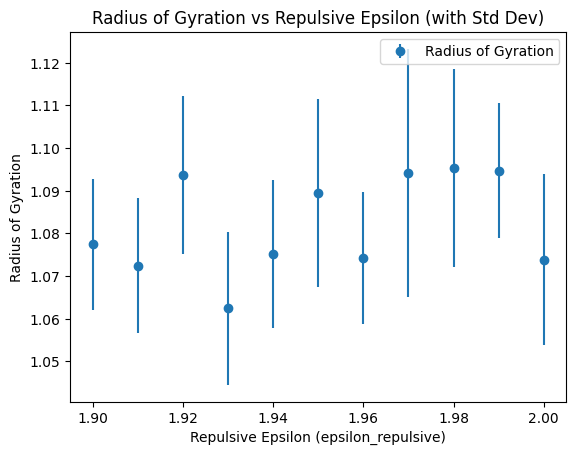

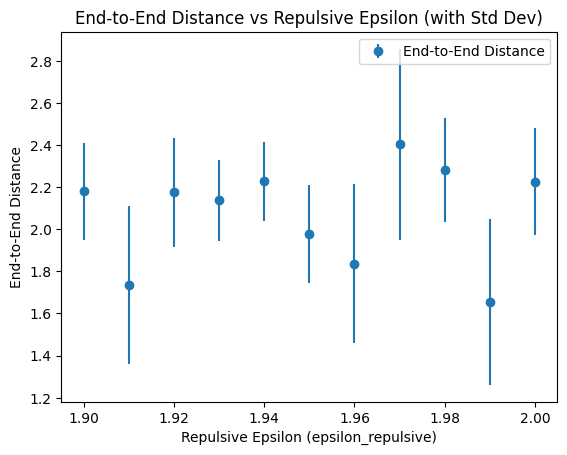

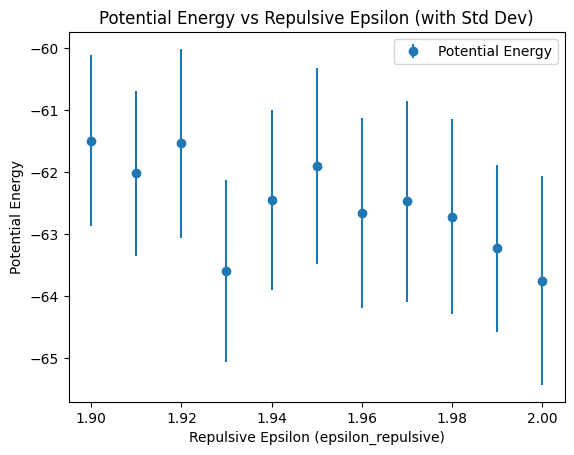

In [24]:
# Epsilon range for the simulation
epsilon_repulsive_values = np.linspace(1.9, 2.0, 11)

# Arrays to store results for different epsilon values
mean_Rg_values = []
std_Rg_values = []
mean_Ree_values = []
std_Ree_values = []
mean_potential_energies = []
std_potential_energies = []

# Loop over each epsilon_repulsive
for epsilon_repulsive in epsilon_repulsive_values:
    # Initialize positions and velocities with ASE
    polymer_chain = initialize_chain_ase(n_particles, box_size, r0)
    positions = polymer_chain.get_positions()
    velocities = initialize_velocities(n_particles, target_temperature, mass)
    forces = compute_harmonic_forces(positions, k, r0, box_size) + compute_lennard_jones_forces(positions, box_size, epsilon_repulsive)

    # Equilibration phase
    for step in range(equilibration_steps):
        positions, velocities, forces = velocity_verlet(positions, velocities, forces, dt, mass, box_size, epsilon_repulsive)
        polymer_chain.set_positions(positions)
        if step % rescale_interval == 0:
            velocities = rescale_velocities(velocities, target_temperature, mass)

    # Sampling phase
    Rg_values = []
    Ree_values = []
    potential_energies = []
    trajectories = []

    for step in range(sampling_steps):
        positions, velocities, forces = velocity_verlet(positions, velocities, forces, dt, mass, box_size, epsilon_repulsive)
        polymer_chain.set_positions(positions)  # Update ASE positions
        if step % rescale_interval == 0:
            velocities = rescale_velocities(velocities, target_temperature, mass)

        # Compute properties
        Rg = calculate_radius_of_gyration(positions)
        Ree = calculate_end_to_end_distance(positions)

        # Calculate potential energy
        E_harmonic = 0.0
        for i in range(n_particles - 1):
            displacement = positions[i + 1] - positions[i]
            displacement = minimum_image(displacement, box_size)
            distance = np.linalg.norm(displacement)
            E_harmonic += 0.5 * k * (distance - r0)**2

        E_LJ = 0.0
        for i in range(len(positions) - 1):
            for j in range(i + 1, len(positions)):
                displacement = positions[j] - positions[i]
                displacement = minimum_image(displacement, box_size)
                distance = np.linalg.norm(displacement)
                if distance < cutoff or distance == 0:
                    continue  # Ignore interactions beyond the cutoff or zero distance
                if abs(i - j) == 2:
                    epsilon_value = epsilon_repulsive
                elif abs(i - j) > 2:
                    epsilon_value = epsilon_attractive
                else:
                    continue
                E_LJ += 4 * epsilon_value * ((sigma / distance)**12 - (sigma / distance)**6)

        potential_energy = E_harmonic + E_LJ

        # Store results
        Rg_values.append(Rg)
        Ree_values.append(Ree)
        potential_energies.append(potential_energy)
        trajectories.append(positions.copy())

    # Convert lists to NumPy arrays
    Rg_values = np.array(Rg_values)
    Ree_values = np.array(Ree_values)
    potential_energies = np.array(potential_energies)
    trajectories = np.array(trajectories)

    # Save the trajectory data for the current epsilon value
    trajectory_file_path = os.path.join(output_dir, f"trajectories_epsilon_{epsilon_repulsive:.2f}.npy")
    np.save(trajectory_file_path, trajectories)
    print(f"Trajectories for epsilon_repulsive {epsilon_repulsive:.2f} saved to: {trajectory_file_path}")

    # Calculate mean and standard deviation for the current epsilon value
    mean_Rg_values.append(np.mean(Rg_values))
    std_Rg_values.append(np.std(Rg_values))

    mean_Ree_values.append(np.mean(Ree_values))
    std_Ree_values.append(np.std(Ree_values))

    mean_potential_energies.append(np.mean(potential_energies))
    std_potential_energies.append(np.std(potential_energies))

# Plotting the results with standard deviation
plt.figure()
plt.errorbar(epsilon_repulsive_values, mean_Rg_values, yerr=std_Rg_values, fmt='o', label='Radius of Gyration')
plt.xlabel('Repulsive Epsilon (epsilon_repulsive)')
plt.ylabel('Radius of Gyration')
plt.title('Radius of Gyration vs Repulsive Epsilon (with Std Dev)')
plt.legend()
plt.show()

plt.figure()
plt.errorbar(epsilon_repulsive_values, mean_Ree_values, yerr=std_Ree_values, fmt='o', label='End-to-End Distance')
plt.xlabel('Repulsive Epsilon (epsilon_repulsive)')
plt.ylabel('End-to-End Distance')
plt.title('End-to-End Distance vs Repulsive Epsilon (with Std Dev)')
plt.legend()
plt.show()

plt.figure()
plt.errorbar(epsilon_repulsive_values, mean_potential_energies, yerr=std_potential_energies, fmt='o', label='Potential Energy')
plt.xlabel('Repulsive Epsilon (epsilon_repulsive)')
plt.ylabel('Potential Energy')
plt.title('Potential Energy vs Repulsive Epsilon (with Std Dev)')
plt.legend()
plt.show()


In [25]:
# Print results for Radius of Gyration
print("Repulsive Epsilon vs Radius of Gyration")
print(f"{'Epsilon_Repulsive':>18} {'Mean Rg':>10} {'Std Rg':>10}")
for epsilon, mean_Rg, std_Rg in zip(epsilon_repulsive_values, mean_Rg_values, std_Rg_values):
    print(f"{epsilon:18.4f} {mean_Rg:10.4f} {std_Rg:10.4f}")

print("\nRepulsive Epsilon vs End-to-End Distance")
print(f"{'Epsilon_Repulsive':>18} {'Mean Ree':>10} {'Std Ree':>10}")
for epsilon, mean_Ree, std_Ree in zip(epsilon_repulsive_values, mean_Ree_values, std_Ree_values):
    print(f"{epsilon:18.4f} {mean_Ree:10.4f} {std_Ree:10.4f}")

print("\nRepulsive Epsilon vs Potential Energy")
print(f"{'Epsilon_Repulsive':>18} {'Mean PE':>10} {'Std PE':>10}")
for epsilon, mean_PE, std_PE in zip(epsilon_repulsive_values, mean_potential_energies, std_potential_energies):
    print(f"{epsilon:18.4f} {mean_PE:10.4f} {std_PE:10.4f}")


Repulsive Epsilon vs Radius of Gyration
 Epsilon_Repulsive    Mean Rg     Std Rg
            1.9000     1.0775     0.0154
            1.9100     1.0724     0.0158
            1.9200     1.0937     0.0186
            1.9300     1.0624     0.0179
            1.9400     1.0752     0.0174
            1.9500     1.0895     0.0220
            1.9600     1.0742     0.0155
            1.9700     1.0942     0.0291
            1.9800     1.0954     0.0232
            1.9900     1.0947     0.0159
            2.0000     1.0739     0.0200

Repulsive Epsilon vs End-to-End Distance
 Epsilon_Repulsive   Mean Ree    Std Ree
            1.9000     2.1797     0.2315
            1.9100     1.7348     0.3746
            1.9200     2.1754     0.2579
            1.9300     2.1365     0.1945
            1.9400     2.2268     0.1883
            1.9500     1.9772     0.2313
            1.9600     1.8368     0.3764
            1.9700     2.4030     0.4538
            1.9800     2.2824     0.2469
            1.99

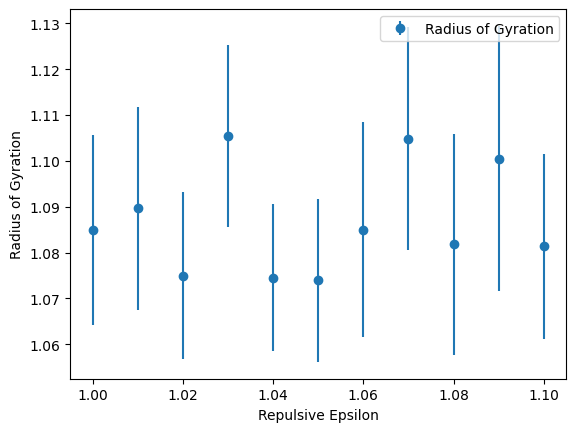

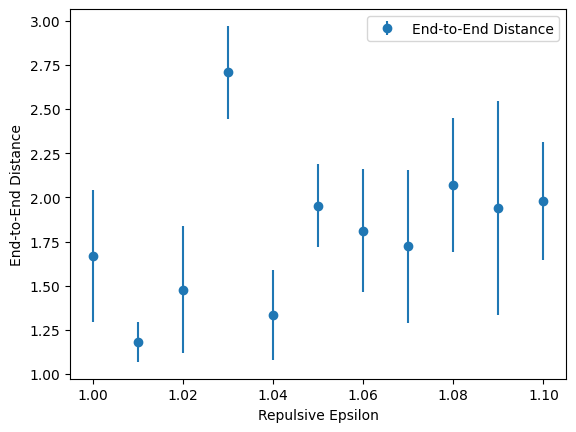

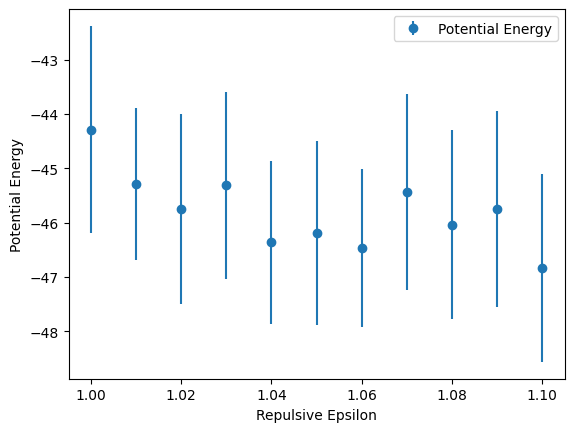

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ase import Atoms
import os

# Set random seed for reproducibility
np.random.seed(42)

# Simulation parameters
dt = 0.01
equilibration_steps = 40000
sampling_steps = 10000
box_size = 100.0
k = 1.0
mass = 1.0
r0 = 1.0
rescale_interval = 100
n_particles = 20
epsilon_attractive = 0.5
sigma = 1.0
cutoff = 1e-6 * sigma
k_B = 1.0
target_temperature = 0.1

# Directory to store trajectories
output_dir = "trajectories_output"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Initialize Positions and Velocities
def initialize_chain_ase(n_particles, box_size, r0):
    positions = np.zeros((n_particles, 3))
    current_position = np.array([box_size / 2, box_size / 2, box_size / 2])
    positions[0] = current_position
    for i in range(1, n_particles):
        direction = np.random.randn(3)
        direction /= np.linalg.norm(direction)
        next_position = current_position + r0 * direction
        positions[i] = next_position % box_size
        current_position = positions[i]
    polymer_chain = Atoms(positions=positions, symbols='C' * n_particles, cell=[box_size, box_size, box_size], pbc=True)
    return polymer_chain

def initialize_velocities(n_particles, target_temperature, mass):
    velocities = np.random.normal(0, np.sqrt(k_B * target_temperature / mass), (n_particles, 3))
    velocities -= np.mean(velocities, axis=0)
    return velocities

# Apply Periodic Boundary Conditions
def apply_pbc(position, box_size):
    return position % box_size

# Compute Forces
def minimum_image(displacement, box_size):
    return displacement - box_size * np.round(displacement / box_size)

# Harmonic Forces
def compute_harmonic_forces(positions, k, r0, box_size):
    forces = np.zeros_like(positions)
    for i in range(len(positions) - 1):
        displacement = positions[i + 1] - positions[i]
        displacement = minimum_image(displacement, box_size)
        distance = np.linalg.norm(displacement)
        if distance != 0:
            force_magnitude = -k * (distance - r0)
            force = force_magnitude * (displacement / distance)
            forces[i] -= force
            forces[i + 1] += force
    return forces

# Lennard-Jones Forces
def compute_lennard_jones_forces(positions, epsilon, sigma, box_size, interaction_type):
    forces = np.zeros_like(positions)
    for i in range(len(positions) - 1):
        for j in range(i + 1, len(positions)):
            displacement = positions[j] - positions[i]
            displacement = minimum_image(displacement, box_size)
            distance = np.linalg.norm(displacement)
            if distance < cutoff or distance == 0:
                continue
            if interaction_type == 'repulsive' and abs(i - j) == 2:
                epsilon_value = epsilon
            elif interaction_type == 'attractive' and abs(i - j) > 2:
                epsilon_value = epsilon
            else:
                continue
            force_magnitude = 24 * epsilon_value * ((sigma / distance)**12 - 0.5 * (sigma / distance)**6) / distance
            force = force_magnitude * (displacement / distance)
            forces[i] -= force
            forces[j] += force
    return forces

# Velocity Verlet Integration
def velocity_verlet_with_separate_forces(positions, velocities, dt, mass, box_size, k, r0, epsilon_repulsive, epsilon_attractive):
    forces_harmonic = compute_harmonic_forces(positions, k, r0, box_size)
    forces_repulsive = compute_lennard_jones_forces(positions, epsilon_repulsive, sigma, box_size, 'repulsive')
    forces_attractive = compute_lennard_jones_forces(positions, epsilon_attractive, sigma, box_size, 'attractive')
    total_forces = forces_harmonic + forces_repulsive + forces_attractive

    velocities += 0.5 * total_forces / mass * dt
    positions += velocities * dt
    positions = apply_pbc(positions, box_size)

    forces_harmonic = compute_harmonic_forces(positions, k, r0, box_size)
    forces_repulsive = compute_lennard_jones_forces(positions, epsilon_repulsive, sigma, box_size, 'repulsive')
    forces_attractive = compute_lennard_jones_forces(positions, epsilon_attractive, sigma, box_size, 'attractive')
    total_forces = forces_harmonic + forces_repulsive + forces_attractive

    velocities += 0.5 * total_forces / mass * dt
    return positions, velocities, total_forces

# Velocity Rescaling Thermostat
def rescale_velocities(velocities, target_temperature, mass):
    kinetic_energy = 0.5 * mass * np.sum(np.linalg.norm(velocities, axis=1)**2)
    current_temperature = (2 / 3) * kinetic_energy / (len(velocities) * k_B)
    scaling_factor = np.sqrt(target_temperature / current_temperature)
    velocities *= scaling_factor
    return velocities

# Analysis Functions
def calculate_radius_of_gyration(positions):
    center_of_mass = np.mean(positions, axis=0)
    Rg_squared = np.mean(np.sum((positions - center_of_mass)**2, axis=1))
    return np.sqrt(Rg_squared)

def calculate_end_to_end_distance(positions):
    return np.linalg.norm(positions[-1] - positions[0])

# Epsilon range for the simulation
epsilon_repulsive_values = np.linspace(1.0, 1.1, 11)

# Arrays to store results
mean_Rg_values = []
std_Rg_values = []
mean_Ree_values = []
std_Ree_values = []
mean_potential_energies = []
std_potential_energies = []

# Loop over each epsilon_repulsive
for epsilon_repulsive in epsilon_repulsive_values:
    epsilon_attractive = 0.5
    polymer_chain = initialize_chain_ase(n_particles, box_size, r0)
    positions = polymer_chain.get_positions()
    velocities = initialize_velocities(n_particles, target_temperature, mass)

    for step in range(equilibration_steps):
        positions, velocities, forces = velocity_verlet_with_separate_forces(
            positions, velocities, dt, mass, box_size, k, r0, epsilon_repulsive, epsilon_attractive
        )
        if step % rescale_interval == 0:
            velocities = rescale_velocities(velocities, target_temperature, mass)

    # Sampling phase
    Rg_values = []
    Ree_values = []
    potential_energies = []
    for step in range(sampling_steps):
        positions, velocities, forces = velocity_verlet_with_separate_forces(
            positions, velocities, dt, mass, box_size, k, r0, epsilon_repulsive, epsilon_attractive
        )
        if step % rescale_interval == 0:
            velocities = rescale_velocities(velocities, target_temperature, mass)

        Rg_values.append(calculate_radius_of_gyration(positions))
        Ree_values.append(calculate_end_to_end_distance(positions))

        # Calculate potential energy
        E_harmonic = 0.0
        for i in range(n_particles - 1):
            displacement = positions[i + 1] - positions[i]
            displacement = minimum_image(displacement, box_size)
            distance = np.linalg.norm(displacement)
            E_harmonic += 0.5 * k * (distance - r0)**2

        E_repulsive = 0.0
        E_attractive = 0.0
        for i in range(len(positions) - 1):
            for j in range(i + 1, len(positions)):
                displacement = positions[j] - positions[i]
                displacement = minimum_image(displacement, box_size)
                distance = np.linalg.norm(displacement)
                if distance < cutoff or distance == 0:
                    continue
                if abs(i - j) == 2:
                    epsilon_value = epsilon_repulsive
                    E_repulsive += 4 * epsilon_value * ((sigma / distance)**12 - (sigma / distance)**6)
                elif abs(i - j) > 2:
                    epsilon_value = epsilon_attractive
                    E_attractive += 4 * epsilon_value * ((sigma / distance)**12 - (sigma / distance)**6)

        potential_energy = E_harmonic + E_repulsive + E_attractive
        potential_energies.append(potential_energy)

    mean_Rg_values.append(np.mean(Rg_values))
    std_Rg_values.append(np.std(Rg_values))
    mean_Ree_values.append(np.mean(Ree_values))
    std_Ree_values.append(np.std(Ree_values))
    mean_potential_energies.append(np.mean(potential_energies))
    std_potential_energies.append(np.std(potential_energies))

# Plot results
plt.figure()
plt.errorbar(epsilon_repulsive_values, mean_Rg_values, yerr=std_Rg_values, fmt='o', label='Radius of Gyration')
plt.xlabel('Repulsive Epsilon')
plt.ylabel('Radius of Gyration')
plt.legend()
plt.show()

plt.figure()
plt.errorbar(epsilon_repulsive_values, mean_Ree_values, yerr=std_Ree_values, fmt='o', label='End-to-End Distance')
plt.xlabel('Repulsive Epsilon')
plt.ylabel('End-to-End Distance')
plt.legend()
plt.show()

plt.figure()
plt.errorbar(epsilon_repulsive_values, mean_potential_energies, yerr=std_potential_energies, fmt='o', label='Potential Energy')
plt.xlabel('Repulsive Epsilon')
plt.ylabel('Potential Energy')
plt.legend()
plt.show()


In [2]:
# Print results for Radius of Gyration
print("Repulsive Epsilon vs Radius of Gyration")
print(f"{'Epsilon_Repulsive':>18} {'Mean Rg':>10} {'Std Rg':>10}")
for epsilon, mean_Rg, std_Rg in zip(epsilon_repulsive_values, mean_Rg_values, std_Rg_values):
    print(f"{epsilon:18.4f} {mean_Rg:10.4f} {std_Rg:10.4f}")

print("\nRepulsive Epsilon vs End-to-End Distance")
print(f"{'Epsilon_Repulsive':>18} {'Mean Ree':>10} {'Std Ree':>10}")
for epsilon, mean_Ree, std_Ree in zip(epsilon_repulsive_values, mean_Ree_values, std_Ree_values):
    print(f"{epsilon:18.4f} {mean_Ree:10.4f} {std_Ree:10.4f}")

print("\nRepulsive Epsilon vs Potential Energy")
print(f"{'Epsilon_Repulsive':>18} {'Mean PE':>10} {'Std PE':>10}")
for epsilon, mean_PE, std_PE in zip(epsilon_repulsive_values, mean_potential_energies, std_potential_energies):
    print(f"{epsilon:18.4f} {mean_PE:10.4f} {std_PE:10.4f}")


Repulsive Epsilon vs Radius of Gyration
 Epsilon_Repulsive    Mean Rg     Std Rg
            1.0000     1.0849     0.0208
            1.0100     1.0896     0.0222
            1.0200     1.0750     0.0183
            1.0300     1.1054     0.0199
            1.0400     1.0745     0.0160
            1.0500     1.0739     0.0178
            1.0600     1.0850     0.0234
            1.0700     1.1049     0.0243
            1.0800     1.0818     0.0242
            1.0900     1.1005     0.0289
            1.1000     1.0813     0.0201

Repulsive Epsilon vs End-to-End Distance
 Epsilon_Repulsive   Mean Ree    Std Ree
            1.0000     1.6684     0.3750
            1.0100     1.1805     0.1116
            1.0200     1.4767     0.3597
            1.0300     2.7066     0.2631
            1.0400     1.3356     0.2540
            1.0500     1.9538     0.2365
            1.0600     1.8122     0.3491
            1.0700     1.7235     0.4325
            1.0800     2.0706     0.3792
            1.09

Trajectories for epsilon_repulsive 1.00 saved to: C:\Users\khh38\Desktop\PhD\Class\comp-prob-solv\Project_2\trajectories_output\trajectories_epsilon_1.00.npy
Trajectories for epsilon_repulsive 1.01 saved to: C:\Users\khh38\Desktop\PhD\Class\comp-prob-solv\Project_2\trajectories_output\trajectories_epsilon_1.01.npy
Trajectories for epsilon_repulsive 1.02 saved to: C:\Users\khh38\Desktop\PhD\Class\comp-prob-solv\Project_2\trajectories_output\trajectories_epsilon_1.02.npy
Trajectories for epsilon_repulsive 1.03 saved to: C:\Users\khh38\Desktop\PhD\Class\comp-prob-solv\Project_2\trajectories_output\trajectories_epsilon_1.03.npy
Trajectories for epsilon_repulsive 1.04 saved to: C:\Users\khh38\Desktop\PhD\Class\comp-prob-solv\Project_2\trajectories_output\trajectories_epsilon_1.04.npy
Trajectories for epsilon_repulsive 1.05 saved to: C:\Users\khh38\Desktop\PhD\Class\comp-prob-solv\Project_2\trajectories_output\trajectories_epsilon_1.05.npy
Trajectories for epsilon_repulsive 1.06 saved to: C:

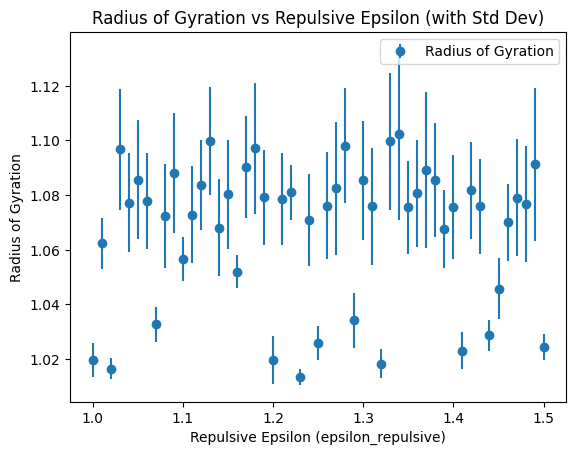

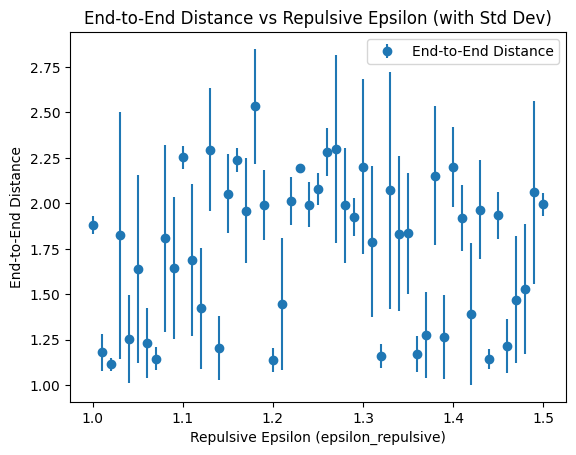

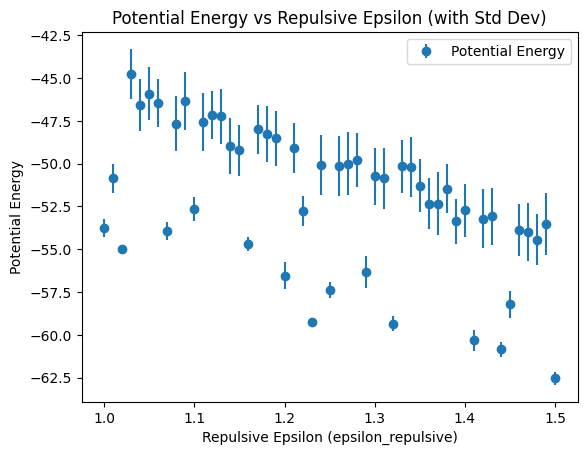

In [2]:
# 150000 stabilization
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from ase import Atoms
from ase.visualize import view
import os

# Set random seed for reproducibility
np.random.seed(42)

# Simulation parameters
dt = 0.01  # Time step
equilibration_steps = 140000  # Equilibration steps
sampling_steps = 10000  # Sampling steps
box_size = 100.0  # Size of the cubic box
k = 1.0  # Spring constant
mass = 1.0  # Particle mass
r0 = 1.0  # Equilibrium bond length
rescale_interval = 100  # Steps between velocity rescaling
n_particles = 20  # Number of particles
epsilon_attractive = 0.5  # Depth of attractive LJ potential
sigma = 1.0  # LJ potential parameter
cutoff = 1e-6 * sigma  # Reduce cutoff to limit attraction range
k_B = 1.0  # Boltzmann constant
target_temperature = 0.1  # Target temperature

# Directory to store trajectories
output_dir = r"C:\Users\khh38\Desktop\PhD\Class\comp-prob-solv\Project_2\trajectories_output"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Initialize Positions and Velocities with ASE Atoms
def initialize_chain_ase(n_particles, box_size, r0):
    """Initialize polymer chain positions with ASE."""
    positions = np.zeros((n_particles, 3))
    current_position = np.array([box_size / 2, box_size / 2, box_size / 2])
    positions[0] = current_position
    for i in range(1, n_particles):
        direction = np.random.randn(3)
        direction /= np.linalg.norm(direction)
        next_position = current_position + r0 * direction
        positions[i] = next_position % box_size
        current_position = positions[i]

    # Create ASE Atoms object
    polymer_chain = Atoms(positions=positions, symbols='C' * n_particles, cell=[box_size, box_size, box_size], pbc=True)
    return polymer_chain

def initialize_velocities(n_particles, target_temperature, mass):
    velocities = np.random.normal(0, np.sqrt(k_B * target_temperature / mass), (n_particles, 3))
    velocities -= np.mean(velocities, axis=0)  # Remove net momentum
    return velocities

# Apply Periodic Boundary Conditions
def apply_pbc(position, box_size):
    return position % box_size

# Compute Forces
def minimum_image(displacement, box_size):
    return displacement - box_size * np.round(displacement / box_size)

# Harmonic Forces
def compute_harmonic_forces(positions, k, r0, box_size):
    forces = np.zeros_like(positions)
    for i in range(len(positions) - 1):
        displacement = positions[i + 1] - positions[i]
        displacement = minimum_image(displacement, box_size)
        distance = np.linalg.norm(displacement)
        if distance != 0:
            force_magnitude = -k * (distance - r0)
            force = force_magnitude * (displacement / distance)
            forces[i] -= force
            forces[i + 1] += force
    return forces

# Lennard-Jones Forces
def compute_lennard_jones_forces(positions, box_size, epsilon_repulsive):
    forces = np.zeros_like(positions)
    for i in range(len(positions) - 1):
        for j in range(i + 1, len(positions)):
            displacement = positions[j] - positions[i]
            displacement = minimum_image(displacement, box_size)
            distance = np.linalg.norm(displacement)
            if distance < cutoff or distance == 0:
                continue  # Ignore interactions beyond the cutoff or zero distance
            if abs(i - j) == 2:
                epsilon_value = epsilon_repulsive
            elif abs(i - j) > 2:
                epsilon_value = epsilon_attractive
            else:
                continue
            force_magnitude = 24 * epsilon_value * ((sigma / distance)**12 - 0.5 * (sigma / distance)**6) / distance
            force = force_magnitude * (displacement / distance)
            forces[i] -= force
            forces[j] += force
    return forces

# Velocity Verlet Integration
def velocity_verlet(positions, velocities, forces, dt, mass, box_size, epsilon_repulsive):
    velocities += 0.5 * forces / mass * dt
    positions += velocities * dt
    positions = apply_pbc(positions, box_size)
    new_forces = compute_harmonic_forces(positions, k, r0, box_size) + compute_lennard_jones_forces(positions, box_size, epsilon_repulsive)
    velocities += 0.5 * new_forces / mass * dt
    return positions, velocities, new_forces

# Velocity Rescaling Thermostat
def rescale_velocities(velocities, target_temperature, mass):
    kinetic_energy = 0.5 * mass * np.sum(np.linalg.norm(velocities, axis=1)**2)
    current_temperature = (2 / 3) * kinetic_energy / (len(velocities) * k_B)
    scaling_factor = np.sqrt(target_temperature / current_temperature)
    velocities *= scaling_factor
    return velocities

# Analysis Functions
def calculate_radius_of_gyration(positions):
    center_of_mass = np.mean(positions, axis=0)
    Rg_squared = np.mean(np.sum((positions - center_of_mass)**2, axis=1))
    Rg = np.sqrt(Rg_squared)
    return Rg

def calculate_end_to_end_distance(positions):
    Ree = np.linalg.norm(positions[-1] - positions[0])
    return Ree

# Epsilon range for the simulation
epsilon_repulsive_values = np.linspace(1.0, 1.5, 51)

# Arrays to store results for different epsilon values
mean_Rg_values = []
std_Rg_values = []
mean_Ree_values = []
std_Ree_values = []
mean_potential_energies = []
std_potential_energies = []

# Loop over each epsilon_repulsive
for epsilon_repulsive in epsilon_repulsive_values:
    # Initialize positions and velocities with ASE
    polymer_chain = initialize_chain_ase(n_particles, box_size, r0)
    positions = polymer_chain.get_positions()
    velocities = initialize_velocities(n_particles, target_temperature, mass)
    forces = compute_harmonic_forces(positions, k, r0, box_size) + compute_lennard_jones_forces(positions, box_size, epsilon_repulsive)

    # Equilibration phase
    for step in range(equilibration_steps):
        positions, velocities, forces = velocity_verlet(positions, velocities, forces, dt, mass, box_size, epsilon_repulsive)
        polymer_chain.set_positions(positions)
        if step % rescale_interval == 0:
            velocities = rescale_velocities(velocities, target_temperature, mass)

    # Sampling phase
    Rg_values = []
    Ree_values = []
    potential_energies = []
    trajectories = []

    for step in range(sampling_steps):
        positions, velocities, forces = velocity_verlet(positions, velocities, forces, dt, mass, box_size, epsilon_repulsive)
        polymer_chain.set_positions(positions)  # Update ASE positions
        if step % rescale_interval == 0:
            velocities = rescale_velocities(velocities, target_temperature, mass)

        # Compute properties
        Rg = calculate_radius_of_gyration(positions)
        Ree = calculate_end_to_end_distance(positions)

        # Calculate potential energy
        E_harmonic = 0.0
        for i in range(n_particles - 1):
            displacement = positions[i + 1] - positions[i]
            displacement = minimum_image(displacement, box_size)
            distance = np.linalg.norm(displacement)
            E_harmonic += 0.5 * k * (distance - r0)**2

        E_LJ = 0.0
        for i in range(len(positions) - 1):
            for j in range(i + 1, len(positions)):
                displacement = positions[j] - positions[i]
                displacement = minimum_image(displacement, box_size)
                distance = np.linalg.norm(displacement)
                if distance < cutoff or distance == 0:
                    continue  # Ignore interactions beyond the cutoff or zero distance
                if abs(i - j) == 2:
                    epsilon_value = epsilon_repulsive
                elif abs(i - j) > 2:
                    epsilon_value = epsilon_attractive
                else:
                    continue
                E_LJ += 4 * epsilon_value * ((sigma / distance)**12 - (sigma / distance)**6)

        potential_energy = E_harmonic + E_LJ

        # Store results
        Rg_values.append(Rg)
        Ree_values.append(Ree)
        potential_energies.append(potential_energy)
        trajectories.append(positions.copy())

    # Convert lists to NumPy arrays
    Rg_values = np.array(Rg_values)
    Ree_values = np.array(Ree_values)
    potential_energies = np.array(potential_energies)
    trajectories = np.array(trajectories)

    # Save the trajectory data for the current epsilon value
    trajectory_file_path = os.path.join(output_dir, f"trajectories_epsilon_{epsilon_repulsive:.2f}.npy")
    np.save(trajectory_file_path, trajectories)
    print(f"Trajectories for epsilon_repulsive {epsilon_repulsive:.2f} saved to: {trajectory_file_path}")

    # Calculate mean and standard deviation for the current epsilon value
    mean_Rg_values.append(np.mean(Rg_values))
    std_Rg_values.append(np.std(Rg_values))

    mean_Ree_values.append(np.mean(Ree_values))
    std_Ree_values.append(np.std(Ree_values))

    mean_potential_energies.append(np.mean(potential_energies))
    std_potential_energies.append(np.std(potential_energies))

# Plotting the results with standard deviation
plt.figure()
plt.errorbar(epsilon_repulsive_values, mean_Rg_values, yerr=std_Rg_values, fmt='o', label='Radius of Gyration')
plt.xlabel('Repulsive Epsilon (epsilon_repulsive)')
plt.ylabel('Radius of Gyration')
plt.title('Radius of Gyration vs Repulsive Epsilon (with Std Dev)')
plt.legend()
plt.show()

plt.figure()
plt.errorbar(epsilon_repulsive_values, mean_Ree_values, yerr=std_Ree_values, fmt='o', label='End-to-End Distance')
plt.xlabel('Repulsive Epsilon (epsilon_repulsive)')
plt.ylabel('End-to-End Distance')
plt.title('End-to-End Distance vs Repulsive Epsilon (with Std Dev)')
plt.legend()
plt.show()

plt.figure()
plt.errorbar(epsilon_repulsive_values, mean_potential_energies, yerr=std_potential_energies, fmt='o', label='Potential Energy')
plt.xlabel('Repulsive Epsilon (epsilon_repulsive)')
plt.ylabel('Potential Energy')
plt.title('Potential Energy vs Repulsive Epsilon (with Std Dev)')
plt.legend()
plt.show()


In [3]:
# Print results for Radius of Gyration
print("Repulsive Epsilon vs Radius of Gyration")
print(f"{'Epsilon_Repulsive':>18} {'Mean Rg':>10} {'Std Rg':>10}")
for epsilon, mean_Rg, std_Rg in zip(epsilon_repulsive_values, mean_Rg_values, std_Rg_values):
    print(f"{epsilon:18.4f} {mean_Rg:10.4f} {std_Rg:10.4f}")

print("\nRepulsive Epsilon vs End-to-End Distance")
print(f"{'Epsilon_Repulsive':>18} {'Mean Ree':>10} {'Std Ree':>10}")
for epsilon, mean_Ree, std_Ree in zip(epsilon_repulsive_values, mean_Ree_values, std_Ree_values):
    print(f"{epsilon:18.4f} {mean_Ree:10.4f} {std_Ree:10.4f}")

print("\nRepulsive Epsilon vs Potential Energy")
print(f"{'Epsilon_Repulsive':>18} {'Mean PE':>10} {'Std PE':>10}")
for epsilon, mean_PE, std_PE in zip(epsilon_repulsive_values, mean_potential_energies, std_potential_energies):
    print(f"{epsilon:18.4f} {mean_PE:10.4f} {std_PE:10.4f}")


Repulsive Epsilon vs Radius of Gyration
 Epsilon_Repulsive    Mean Rg     Std Rg
            1.0000     1.0195     0.0062
            1.0100     1.0623     0.0092
            1.0200     1.0165     0.0037
            1.0300     1.0967     0.0220
            1.0400     1.0772     0.0180
            1.0500     1.0856     0.0218
            1.0600     1.0778     0.0176
            1.0700     1.0327     0.0064
            1.0800     1.0724     0.0191
            1.0900     1.0881     0.0220
            1.1000     1.0565     0.0082
            1.1100     1.0727     0.0178
            1.1200     1.0837     0.0164
            1.1300     1.0998     0.0198
            1.1400     1.0681     0.0178
            1.1500     1.0802     0.0198
            1.1600     1.0520     0.0060
            1.1700     1.0902     0.0186
            1.1800     1.0971     0.0240
            1.1900     1.0792     0.0173
            1.2000     1.0197     0.0087
            1.2100     1.0785     0.0170
            1.220

Trajectories for repulsive 1.00 saved to: C:\Users\khh38\Desktop\PhD\Class\comp-prob-solv\Project_2\trajectories_output\trajectories_Rep_1.00.npy
Trajectories for repulsive 1.01 saved to: C:\Users\khh38\Desktop\PhD\Class\comp-prob-solv\Project_2\trajectories_output\trajectories_Rep_1.01.npy
Trajectories for repulsive 1.02 saved to: C:\Users\khh38\Desktop\PhD\Class\comp-prob-solv\Project_2\trajectories_output\trajectories_Rep_1.02.npy
Trajectories for repulsive 1.03 saved to: C:\Users\khh38\Desktop\PhD\Class\comp-prob-solv\Project_2\trajectories_output\trajectories_Rep_1.03.npy
Trajectories for repulsive 1.04 saved to: C:\Users\khh38\Desktop\PhD\Class\comp-prob-solv\Project_2\trajectories_output\trajectories_Rep_1.04.npy
Trajectories for repulsive 1.05 saved to: C:\Users\khh38\Desktop\PhD\Class\comp-prob-solv\Project_2\trajectories_output\trajectories_Rep_1.05.npy
Trajectories for repulsive 1.06 saved to: C:\Users\khh38\Desktop\PhD\Class\comp-prob-solv\Project_2\trajectories_output\traj

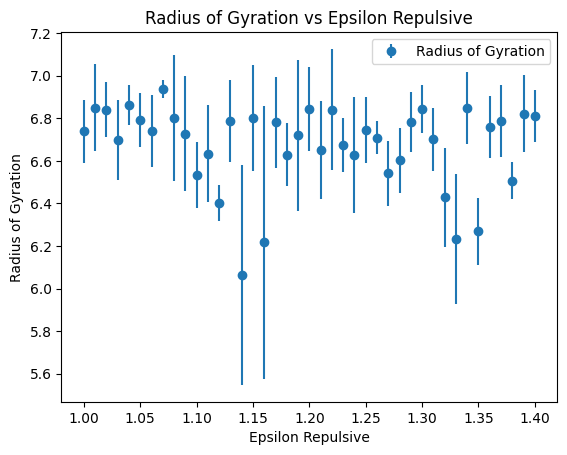

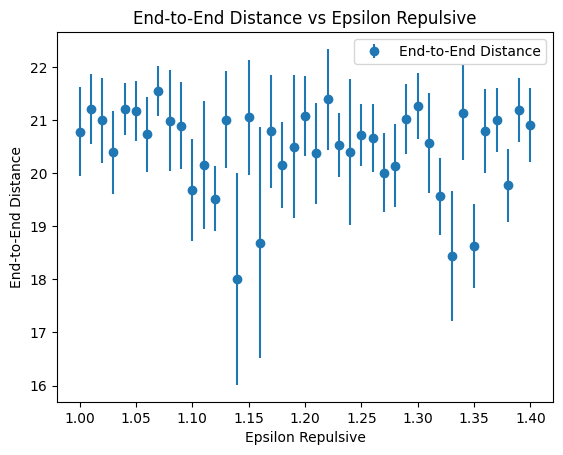

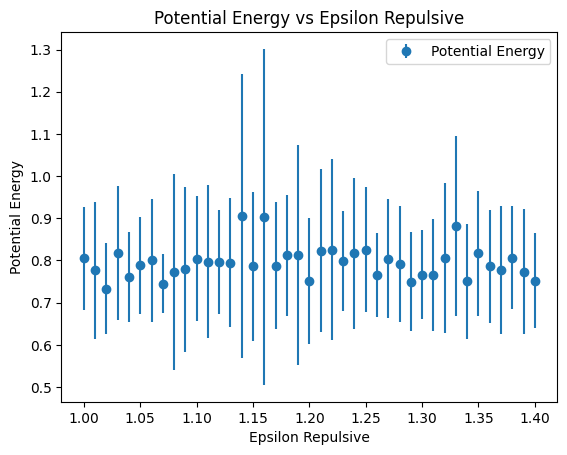

In [8]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from ase import Atoms
from ase.visualize import view

# Set random seed for reproducibility
np.random.seed(42)

# Simulation parameters
dt = 0.01  # Time step
total_steps = 150000  # Number of steps (20,000 in total)
box_size = 100.0  # Size of the cubic box
mass = 1.0  # Particle mass
r0 = 1.0  # Equilibrium bond length
k = 1
rescale_interval = 100  # Steps between velocity rescaling
n_particles = 20  # Number of particles
epsilon_attractive = 0.5  # Depth of attractive LJ potential
sigma = 1.0  # LJ potential parameter
cutoff = 1e-6 * sigma  # Reduce cutoff to limit attraction range
k_B = 1.0  # Boltzmann constant
target_temperature = 0.1  # Target temperature

# Directory to store trajectories
output_dir = r"C:\Users\khh38\Desktop\PhD\Class\comp-prob-solv\Project_2\trajectories_output"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Initialize Positions and Velocities
def initialize_chain(n_particles, box_size, r0):
    positions = np.zeros((n_particles, 3))
    current_position = np.array([box_size / 2, box_size / 2, box_size / 2])
    positions[0] = current_position
    for i in range(1, n_particles):
        direction = np.random.randn(3)
        direction /= np.linalg.norm(direction)
        next_position = current_position + r0 * direction
        positions[i] = next_position % box_size
        current_position = positions[i]
    return positions

def initialize_velocities(n_particles, target_temperature, mass):
    velocities = np.random.normal(0, np.sqrt(k_B * target_temperature / mass), (n_particles, 3))
    velocities -= np.mean(velocities, axis=0)  # Remove net momentum
    return velocities

# Apply Periodic Boundary Conditions
def apply_pbc(position, box_size):
    return position % box_size

# Compute Forces
def minimum_image(displacement, box_size):
    return displacement - box_size * np.round(displacement / box_size)

# Harmonic Forces
def compute_harmonic_forces(positions, k, r0, box_size):
    forces = np.zeros_like(positions)
    for i in range(n_particles - 1):
        displacement = positions[i + 1] - positions[i]
        displacement = minimum_image(displacement, box_size)
        distance = np.linalg.norm(displacement)
        force_magnitude = -k * (distance - r0)
        force = force_magnitude * (displacement / distance)
        forces[i] -= force
        forces[i + 1] += force
    return forces

# Lennard-Jones Forces
def compute_lennard_jones_forces(positions, epsilon, sigma, box_size, interaction_type):
    forces = np.zeros_like(positions)
    for i in range(n_particles - 1):
        for j in range(i + 1, n_particles):
            if interaction_type == 'repulsive' and abs(i - j) == 2:
                epsilon_value = epsilon
            elif interaction_type == 'attractive' and abs(i - j) > 2:
                epsilon_value = epsilon_attractive
            else:
                continue
            displacement = positions[j] - positions[i]
            displacement = minimum_image(displacement, box_size)
            distance = np.linalg.norm(displacement)
            if distance < cutoff:
                force_magnitude = 24 * epsilon_value * ((sigma / distance)**12 - 0.5 * (sigma / distance)**6) / distance
                force = force_magnitude * (displacement / distance)
                forces[i] -= force
                forces[j] += force
    return forces

# Velocity Verlet Integration
def velocity_verlet(positions, velocities, forces, dt, mass, k):
    velocities += 0.5 * forces / mass * dt
    positions += velocities * dt
    positions = apply_pbc(positions, box_size)
    new_forces = compute_harmonic_forces(positions, k, r0, box_size) + \
                 compute_lennard_jones_forces(positions, epsilon_repulsive, sigma, box_size, 'repulsive') + \
                 compute_lennard_jones_forces(positions, epsilon_attractive, sigma, box_size, 'attractive')
    velocities += 0.5 * new_forces / mass * dt
    return positions, velocities, new_forces

# Velocity Rescaling Thermostat
def rescale_velocities(velocities, target_temperature, mass):
    kinetic_energy = 0.5 * mass * np.sum(np.linalg.norm(velocities, axis=1)**2)
    current_temperature = (2 / 3) * kinetic_energy / (n_particles * k_B)
    scaling_factor = np.sqrt(target_temperature / current_temperature)
    velocities *= scaling_factor
    return velocities

# Analysis Functions
def calculate_radius_of_gyration(positions):
    center_of_mass = np.mean(positions, axis=0)
    Rg_squared = np.mean(np.sum((positions - center_of_mass)**2, axis=1))
    Rg = np.sqrt(Rg_squared)
    return Rg

def calculate_end_to_end_distance(positions):
    Ree = np.linalg.norm(positions[-1] - positions[0])
    return Ree

# Arrays to store results for different epsilon_repulsive values
epsilon_repulsive_values = np.linspace(1.0, 1.4, 41)  # Vary epsilon_repulsive from 0.1 to 2.0
mean_Rg_values = []
std_Rg_values = []
mean_Ree_values = []
std_Ree_values = []
mean_potential_energies = []
std_potential_energies = []

for epsilon_repulsive in epsilon_repulsive_values:
    # Re-initialize positions and velocities for each epsilon_repulsive value
    positions = initialize_chain(n_particles, box_size, r0)
    velocities = initialize_velocities(n_particles, target_temperature, mass)
    forces = compute_harmonic_forces(positions, k, r0, box_size) + \
             compute_lennard_jones_forces(positions, epsilon_repulsive, sigma, box_size, 'repulsive') + \
             compute_lennard_jones_forces(positions, epsilon_attractive, sigma, box_size, 'attractive')

    # Arrays to store properties during each step after 140,000 steps
    Rg_values = []
    Ree_values = []
    potential_energies = []

    # Run simulation loop
    for step in range(total_steps):
        positions, velocities, forces = velocity_verlet(positions, velocities, forces, dt, mass, k)
        if step % rescale_interval == 0:
            velocities = rescale_velocities(velocities, target_temperature, mass)

        # Store values only after step 140,000
        if step >= 140000:
            # Compute properties for this step
            Rg = calculate_radius_of_gyration(positions)
            Ree = calculate_end_to_end_distance(positions)

            # Calculate potential energy
            E_harmonic = 0.0
            for i in range(n_particles - 1):
                displacement = positions[i + 1] - positions[i]
                displacement = minimum_image(displacement, box_size)
                distance = np.linalg.norm(displacement)
                E_harmonic += 0.5 * k * (distance - r0)**2

            # Lennard-Jones Potentials
            # Revised functions for repulsive and attractive LJ potentials
            def lj_repulsive_potential(r, epsilon, sigma):
                if r < 2**(1/6) * sigma:
                    return 4 * epsilon * ((sigma / r)**12 - (sigma / r)**6 + 0.25)
                return 0.0

            def lj_attractive_potential(r, epsilon, sigma):
                return 4 * epsilon * ((sigma / r)**12 - (sigma / r)**6)

            E_LJ = 0.0
            for i in range(n_particles - 1):
                for j in range(i + 1, n_particles):
                    displacement = positions[j] - positions[i]
                    displacement = minimum_image(displacement, box_size)
                    distance = np.linalg.norm(displacement)
                    if distance < cutoff:
                        if abs(i - j) == 2:
                            # Repulsive Lennard-Jones Potential
                            E_LJ += lj_repulsive_potential(distance, epsilon_repulsive, sigma)
                        elif abs(i - j) > 2:
                            # Attractive Lennard-Jones Potential
                            E_LJ += lj_attractive_potential(distance, epsilon_attractive, sigma)

            potential_energy = E_harmonic + E_LJ

            # Store values
            Rg_values.append(Rg)
            Ree_values.append(Ree)
            potential_energies.append(potential_energy)

    # Convert lists to NumPy arrays for easier calculations
    Rg_values = np.array(Rg_values)
    Ree_values = np.array(Ree_values)
    potential_energies = np.array(potential_energies)
    trajectories = np.array(trajectories)

    # Save the trajectory data for the current temperature
    trajectory_file_path = os.path.join(output_dir, f"trajectories_Rep_{epsilon_repulsive:.2f}.npy")
    np.save(trajectory_file_path, trajectories)
    print(f"Trajectories for repulsive {epsilon_repulsive:.2f} saved to: {trajectory_file_path}")

    # Calculate mean and standard deviation for each property
    mean_Rg_values.append(np.mean(Rg_values))
    std_Rg_values.append(np.std(Rg_values))

    mean_Ree_values.append(np.mean(Ree_values))
    std_Ree_values.append(np.std(Ree_values))

    mean_potential_energies.append(np.mean(potential_energies))
    std_potential_energies.append(np.std(potential_energies))

# Plotting the results with error bars
plt.figure()
plt.errorbar(epsilon_repulsive_values, mean_Rg_values, yerr=std_Rg_values, fmt='o', label='Radius of Gyration')
plt.xlabel('Epsilon Repulsive')
plt.ylabel('Radius of Gyration')
plt.title('Radius of Gyration vs Epsilon Repulsive')
plt.legend()
plt.show()

plt.figure()
plt.errorbar(epsilon_repulsive_values, mean_Ree_values, yerr=std_Ree_values, fmt='o', label='End-to-End Distance')
plt.xlabel('Epsilon Repulsive')
plt.ylabel('End-to-End Distance')
plt.title('End-to-End Distance vs Epsilon Repulsive')
plt.legend()
plt.show()

plt.figure()
plt.errorbar(epsilon_repulsive_values, mean_potential_energies, yerr=std_potential_energies, fmt='o', label='Potential Energy')
plt.xlabel('Epsilon Repulsive')
plt.ylabel('Potential Energy')
plt.title('Potential Energy vs Epsilon Repulsive')
plt.legend()
plt.show()

In [9]:
# Print results for Radius of Gyration
print("Repulsive Epsilon vs Radius of Gyration")
print(f"{'Epsilon_Repulsive':>18} {'Mean Rg':>10} {'Std Rg':>10}")
for epsilon, mean_Rg, std_Rg in zip(epsilon_repulsive_values, mean_Rg_values, std_Rg_values):
    print(f"{epsilon:18.4f} {mean_Rg:10.4f} {std_Rg:10.4f}")

print("\nRepulsive Epsilon vs End-to-End Distance")
print(f"{'Epsilon_Repulsive':>18} {'Mean Ree':>10} {'Std Ree':>10}")
for epsilon, mean_Ree, std_Ree in zip(epsilon_repulsive_values, mean_Ree_values, std_Ree_values):
    print(f"{epsilon:18.4f} {mean_Ree:10.4f} {std_Ree:10.4f}")

print("\nRepulsive Epsilon vs Potential Energy")
print(f"{'Epsilon_Repulsive':>18} {'Mean PE':>10} {'Std PE':>10}")
for epsilon, mean_PE, std_PE in zip(epsilon_repulsive_values, mean_potential_energies, std_potential_energies):
    print(f"{epsilon:18.4f} {mean_PE:10.4f} {std_PE:10.4f}")


Repulsive Epsilon vs Radius of Gyration
 Epsilon_Repulsive    Mean Rg     Std Rg
            1.0000     6.7392     0.1471
            1.0100     6.8492     0.2053
            1.0200     6.8406     0.1296
            1.0300     6.6971     0.1884
            1.0400     6.8614     0.0935
            1.0500     6.7916     0.1254
            1.0600     6.7381     0.1694
            1.0700     6.9363     0.0429
            1.0800     6.8009     0.2953
            1.0900     6.7272     0.2711
            1.1000     6.5318     0.1553
            1.1100     6.6333     0.2272
            1.1200     6.4014     0.0854
            1.1300     6.7878     0.1926
            1.1400     6.0631     0.5155
            1.1500     6.8004     0.2495
            1.1600     6.2169     0.6408
            1.1700     6.7801     0.2139
            1.1800     6.6291     0.1475
            1.1900     6.7210     0.3543
            1.2000     6.8426     0.1965
            1.2100     6.6500     0.2306
            1.220